In this notebook ..

__Modeling Steps:__
1. Initiation and reading the data
2. Defining useful functions
3. Checking info and dtypes of the data
4. Missing Value Detection (be careful with the not null but meaningless info in a column)
5. Missing Value Handling (maybe later)
6. Check the target variable

A. REGRESSION
1. check the distribution of target variable and find the best fit
2. 

## 1. INITIATION & READING DATA

In [20]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np 
import pandas as pd
pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 999)
pd.set_option('display.max_colwidth', -1)

import seaborn as sns
sns.set_style('darkgrid')

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import scipy.stats as st

import lightgbm as lgb

print('** HOUSE PRICES - ADVANCED REGRESSION TECHNIQUES **')
print("-"*25)

import gc
import os
for x in os.listdir("input/"):
    print(x)
print("-"*25)

print ("Initiation is DONE !!")
print("-"*25)

** HOUSE PRICES - ADVANCED REGRESSION TECHNIQUES **
-------------------------
data_description.txt
sample_submission.csv
test.csv
train.csv
-------------------------
Initiation is DONE !!
-------------------------


In [21]:
##### SOME USEFULL FUNCTIONS

## TIMER
import time
from contextlib import contextmanager
@contextmanager
def timer():
    t0 = time.time()
    yield
    t1 = time.time()
    print( 'Runtime: ' + str(round(t1-t0,2)) + ' sn' )
    
    
def null_detector(x):
    missing = x.isnull().sum()
    missing = missing[missing > 0]
    missing.sort_values(ascending=False, inplace=True)
    
    fig, ax = plt.subplots(figsize=(15,6) )
    sns.barplot( x=missing.index, y=missing.values)
    plt.title( f'Total Column: {x.shape[1]} --- Missing Column: {len(missing)} ({round(len(missing)*100/x.shape[1],2)}%) ' )
    plt.xticks(rotation=60)
    
    for p in ax.patches:
        ax.annotate( '{:.2f}'.format(p.get_height()/x.shape[0]),  (p.get_x() , p.get_height() + 3), fontsize=11 )  
    plt.show()
    
    
def target_dist_visualizer(y):
    import scipy.stats as st
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,4) )

    sns.distplot(y, kde=True, fit=st.norm, ax=ax1)
    ax1.set(title='Normal')

    sns.distplot(y, kde=True, fit=st.lognorm, ax=ax2)
    ax2.set(title='Log Normal')

    sns.distplot(y, kde=True, fit=st.johnsonsu, ax=ax3)
    ax3.set(title='Johnson SU')
    plt.show()
    print('-'*120)
    
    df_res = pd.DataFrame({ 'normaltest-stat': [ st.normaltest(y)[0]  ],
                            'normaltest-p'   : [ st.normaltest(y)[1]  ],
                            'shapiro-stat'   : [ st.shapiro(y)[0]     ],
                            'shapiro-p'      : [ st.shapiro(y)[1]     ],
                            'anderson-stat'  : [ st.anderson(y, dist='norm')[0] ],
                            'anderson-crit'  : [ st.anderson(y, dist='norm')[1]  ],
                            'anderson-sgnf'  : [ st.anderson(y, dist='norm')[2]  ]   })
    
    return df_res

    
def num_col_visualizer(train, test, num_cols, target, box_limit=10):

    for col in num_cols:

        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5) )
        # plt.suptitle(col, fontsize=20)

        ## FIRST SUBPLOT
        if train[col].nunique() <= box_limit:
            sns.boxplot(data=train,  x=col, y=target, ax=ax1)
        else:
            sns.scatterplot( data=train,  x=col, y=target, ax=ax1)

        ax1.set( title = col + ' vs. ' + target ) 

        ## SECOND SUBPLOT
        try:
            sns.distplot(train[col], kde=True, ax=ax2)
        except RuntimeError as re:
            if str(re).startswith("Selected KDE bandwidth is 0. Cannot estiamte density."):
                sns.distplot(train[col], kde=True, kde_kws={'bw': 0.1}, ax=ax2)
            else:
                raise re
        ax2.set( title = 'Train --- Null: ' + str(train[col].isnull().sum()) + ' --- Unique: ' + str( train[col].nunique()  ) )

        ## THIRD SUBPLOT
        try:
            sns.distplot(test[col], kde=True, ax=ax3)
        except RuntimeError as re:
            if str(re).startswith("Selected KDE bandwidth is 0. Cannot estiamte density."):
                sns.distplot(test[col], kde=True, kde_kws={'bw': 0.1}, ax=ax3)
            else:
                raise re
        ax3.set( title = 'Test --- Null: ' + str(test[col].isnull().sum())  + ' --- Unique: ' + str( test[col].nunique() ) )

        plt.show()
        print(train[col].describe(include='all'))
        print('-'*120)    


In [22]:
path = 'input/'
out_path = 'output/'

with timer():
    train      = pd.read_csv( f'{path}train.csv')
    test       = pd.read_csv( f'{path}test.csv')
    submission = pd.read_csv( f'{path}sample_submission.csv')

print('Reading Data is DONE !!')
print("-"*25)

print( f'train      shape :  {train.shape}       ')
print( f'test       shape :  {test.shape}        ')
print( f'submission shape :  {submission.shape}  ')

Runtime: 0.1 sn
Reading Data is DONE !!
-------------------------
train      shape :  (1460, 81)       
test       shape :  (1459, 80)        
submission shape :  (1459, 2)  


In [23]:
target   = 'SalePrice'
str_cols = [f for f in train.columns if train.dtypes[f] == 'object']
num_cols = [f for f in train.columns if train.dtypes[f] != 'object']
num_cols.remove(target)
num_cols.remove('Id')

In [24]:
train.dtypes.value_counts()

object     43
int64      35
float64    3 
dtype: int64

## TREATMENT OF TARGET VARIABLES

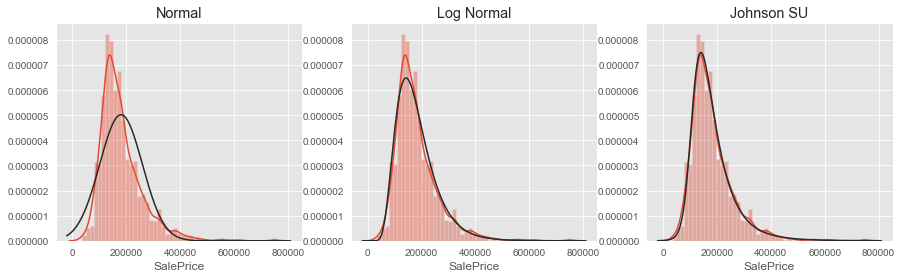

------------------------------------------------------------------------------------------------------------------------


,normaltest-stat,normaltest-p,shapiro-stat,shapiro-p,anderson-stat,anderson-crit,anderson-sgnf
0,610.835911,2.283848e-133,0.869672,3.206248e-33,41.691996,"[0.574, 0.654, 0.785, 0.916, 1.089]","[15.0, 10.0, 5.0, 2.5, 1.0]"


In [25]:
## This part will be improved with advanced methods
y = train[target]
target_dist_visualizer(y)

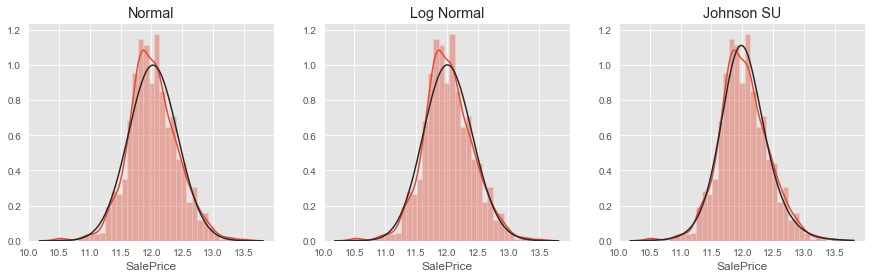

------------------------------------------------------------------------------------------------------------------------


,normaltest-stat,normaltest-p,shapiro-stat,shapiro-p,anderson-stat,anderson-crit,anderson-sgnf
0,25.50701,0.000003,0.991207,1.149068e-07,3.538754,"[0.574, 0.654, 0.785, 0.916, 1.089]","[15.0, 10.0, 5.0, 2.5, 1.0]"


In [26]:
## This part will be improved with advanced methods
y = np.log(train[target])
target_dist_visualizer(y)

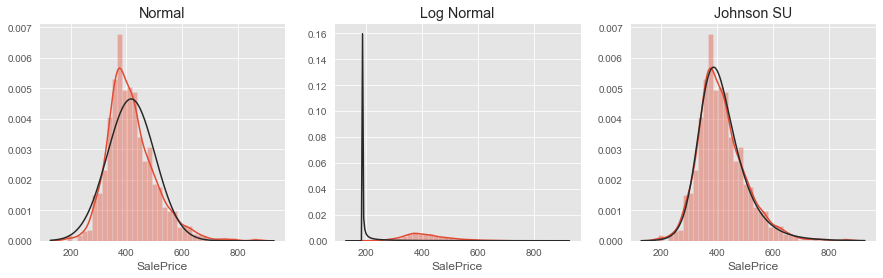

------------------------------------------------------------------------------------------------------------------------


,normaltest-stat,normaltest-p,shapiro-stat,shapiro-p,anderson-stat,anderson-crit,anderson-sgnf
0,228.806241,2.067074e-50,0.955481,1.114370e-20,15.877068,"[0.574, 0.654, 0.785, 0.916, 1.089]","[15.0, 10.0, 5.0, 2.5, 1.0]"


In [27]:
## This part will be improved with advanced methods
y = np.sqrt(train[target])
target_dist_visualizer(y)

In [28]:
## p < 0.05 indicates the rejection of null hypotesis, 
## (H0: that is the series comes from a normal distribution)

In [29]:
train[target] = np.log(train[target])

## NUMERICAL COLUMN VISUALISATION 

In [30]:
print(train.shape)
train = train[ ~( train['GrLivArea']   >= 4000 ) ]
print(train.shape)
train = train[ ~( train['LotFrontage'] >= 200  ) ]
print(train.shape)

(1460, 81)
(1456, 81)
(1455, 81)


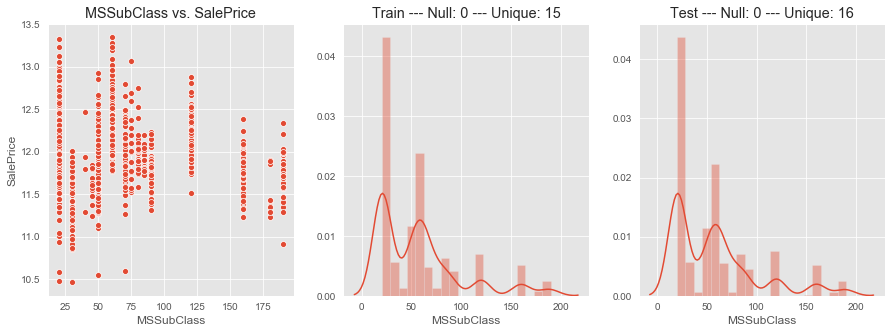

count    1455.000000
mean     56.914089  
std      42.361874  
min      20.000000  
25%      20.000000  
50%      50.000000  
75%      70.000000  
max      190.000000 
Name: MSSubClass, dtype: float64
------------------------------------------------------------------------------------------------------------------------


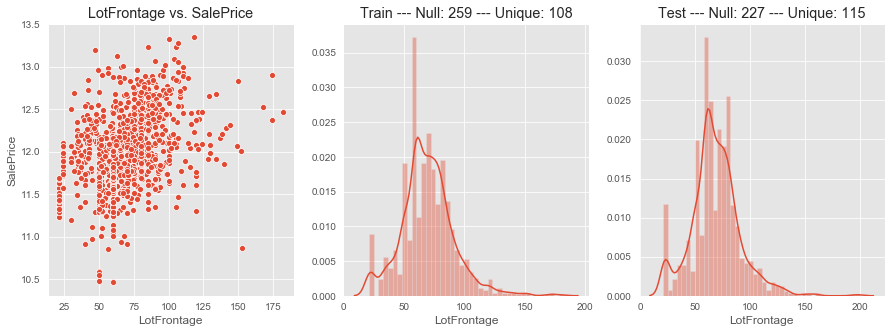

count    1196.000000
mean     69.489967  
std      21.963013  
min      21.000000  
25%      59.000000  
50%      69.000000  
75%      80.000000  
max      182.000000 
Name: LotFrontage, dtype: float64
------------------------------------------------------------------------------------------------------------------------


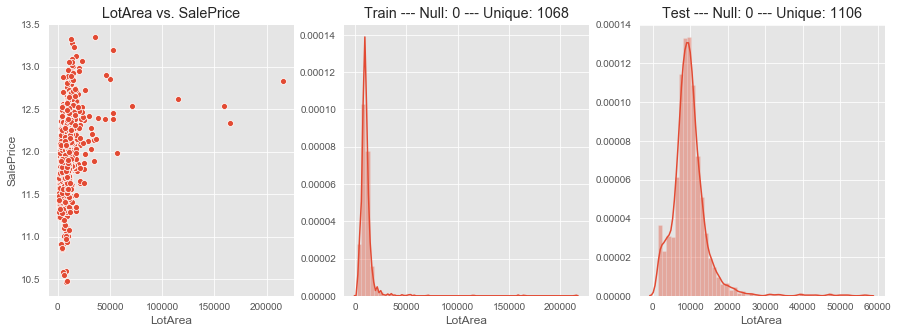

count    1455.000000  
mean     10436.962199 
std      9853.826403  
min      1300.000000  
25%      7537.500000  
50%      9464.000000  
75%      11568.500000 
max      215245.000000
Name: LotArea, dtype: float64
------------------------------------------------------------------------------------------------------------------------


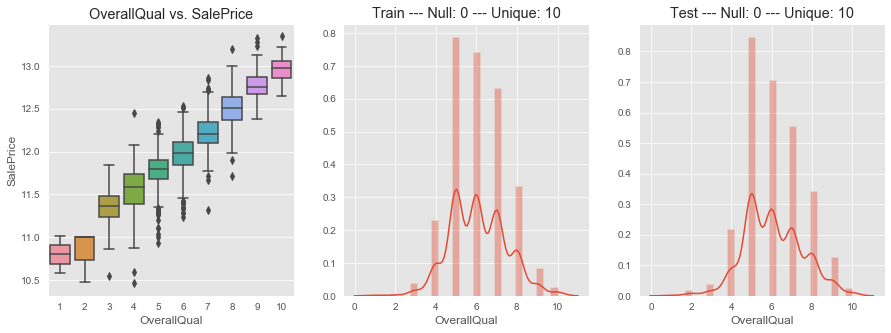

count    1455.000000
mean     6.087973   
std      1.369931   
min      1.000000   
25%      5.000000   
50%      6.000000   
75%      7.000000   
max      10.000000  
Name: OverallQual, dtype: float64
------------------------------------------------------------------------------------------------------------------------


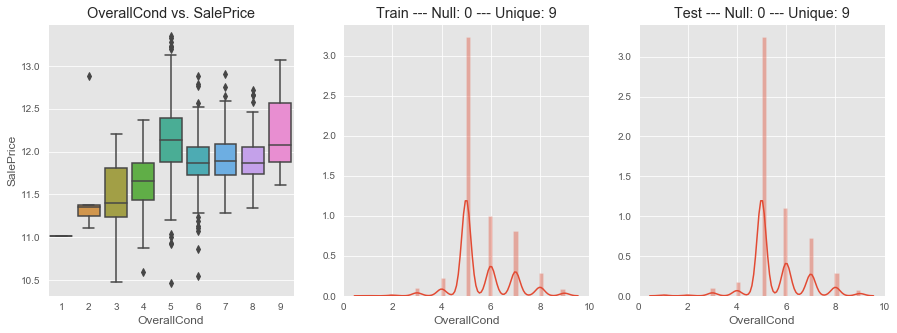

count    1455.000000
mean     5.575258   
std      1.113722   
min      1.000000   
25%      5.000000   
50%      5.000000   
75%      6.000000   
max      9.000000   
Name: OverallCond, dtype: float64
------------------------------------------------------------------------------------------------------------------------


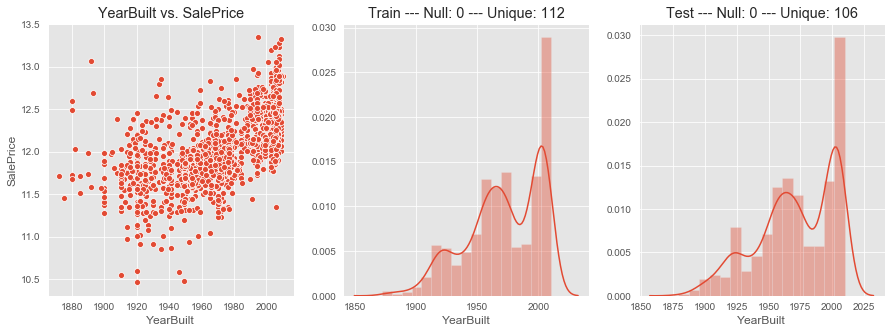

count    1455.000000
mean     1971.193127
std      30.210549  
min      1872.000000
25%      1954.000000
50%      1972.000000
75%      2000.000000
max      2010.000000
Name: YearBuilt, dtype: float64
------------------------------------------------------------------------------------------------------------------------


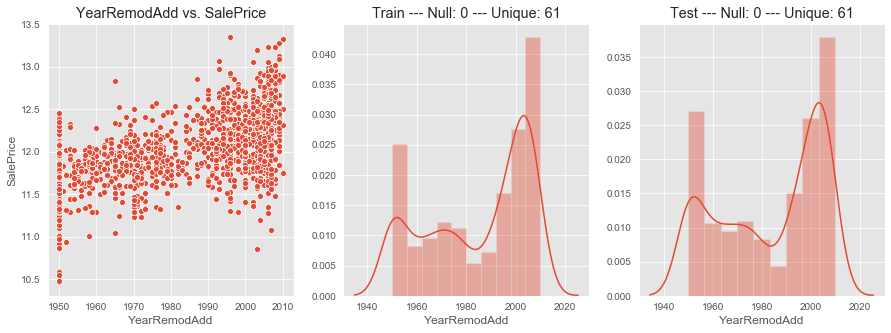

count    1455.000000
mean     1984.804124
std      20.651047  
min      1950.000000
25%      1966.500000
50%      1993.000000
75%      2004.000000
max      2010.000000
Name: YearRemodAdd, dtype: float64
------------------------------------------------------------------------------------------------------------------------


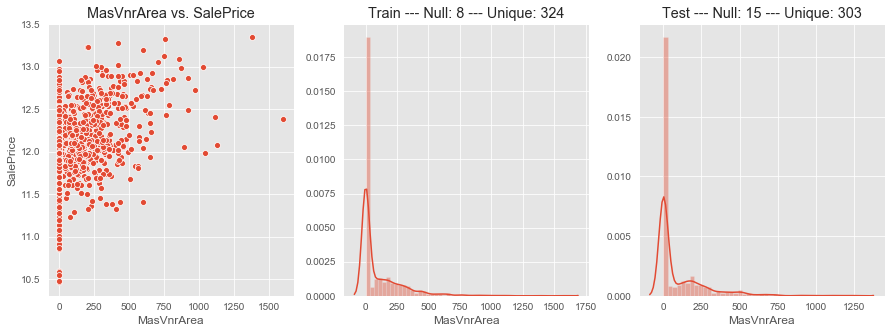

count    1447.000000
mean     102.158258 
std      177.379910 
min      0.000000   
25%      0.000000   
50%      0.000000   
75%      164.500000 
max      1600.000000
Name: MasVnrArea, dtype: float64
------------------------------------------------------------------------------------------------------------------------


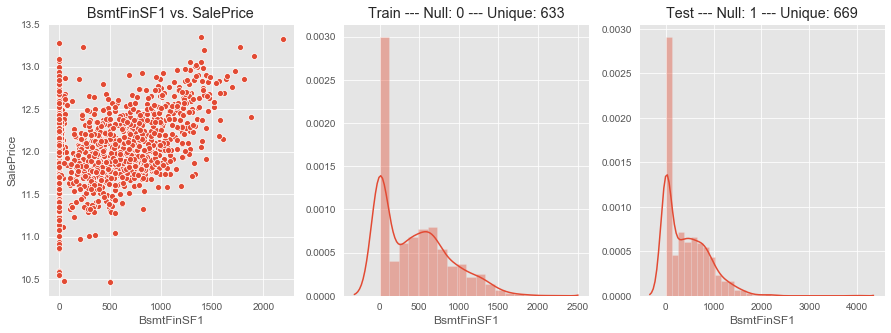

count    1455.000000
mean     436.999313 
std      430.402867 
min      0.000000   
25%      0.000000   
50%      381.000000 
75%      707.000000 
max      2188.000000
Name: BsmtFinSF1, dtype: float64
------------------------------------------------------------------------------------------------------------------------


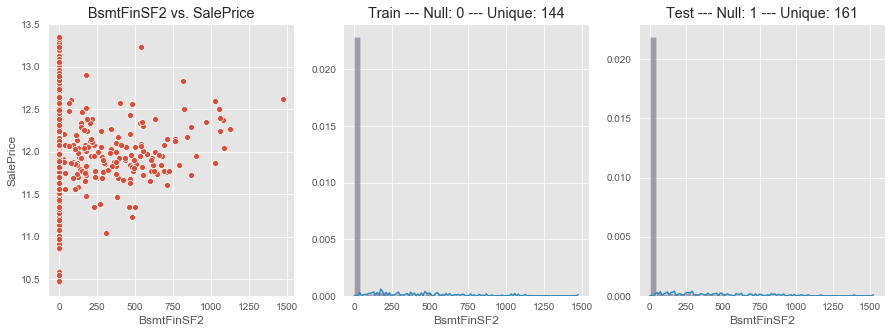

count    1455.000000
mean     46.709278  
std      161.573270 
min      0.000000   
25%      0.000000   
50%      0.000000   
75%      0.000000   
max      1474.000000
Name: BsmtFinSF2, dtype: float64
------------------------------------------------------------------------------------------------------------------------


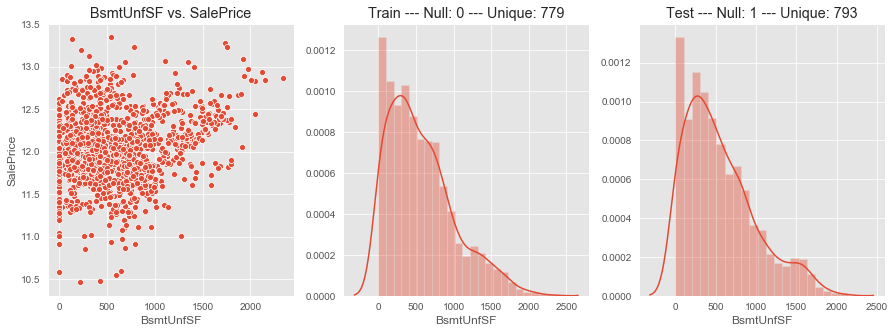

count    1455.000000
mean     567.270103 
std      442.220343 
min      0.000000   
25%      223.000000 
50%      479.000000 
75%      808.000000 
max      2336.000000
Name: BsmtUnfSF, dtype: float64
------------------------------------------------------------------------------------------------------------------------


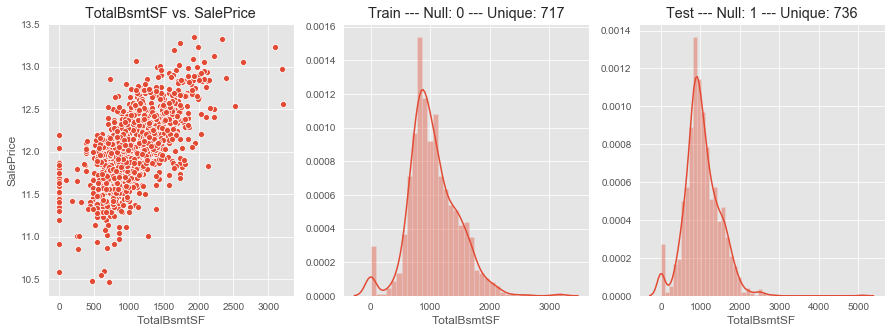

count    1455.000000
mean     1050.978694
std      412.116404 
min      0.000000   
25%      795.500000 
50%      991.000000 
75%      1294.500000
max      3206.000000
Name: TotalBsmtSF, dtype: float64
------------------------------------------------------------------------------------------------------------------------


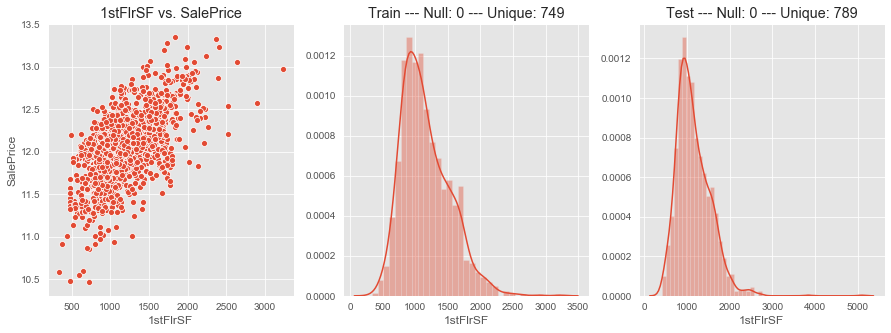

count    1455.000000
mean     1156.481787
std      368.658936 
min      334.000000 
25%      882.000000 
50%      1086.000000
75%      1386.000000
max      3228.000000
Name: 1stFlrSF, dtype: float64
------------------------------------------------------------------------------------------------------------------------


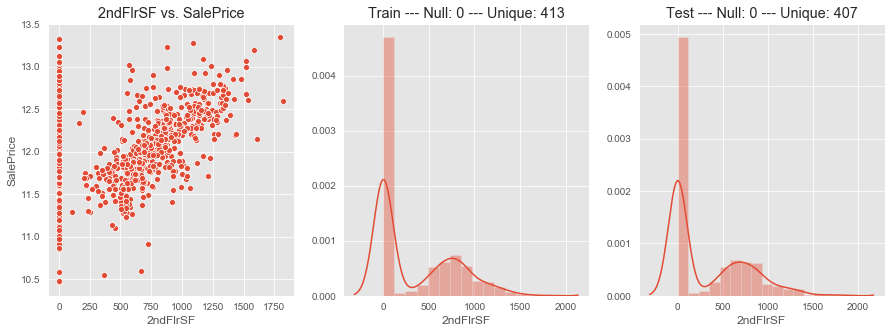

count    1455.000000
mean     343.769072 
std      431.583196 
min      0.000000   
25%      0.000000   
50%      0.000000   
75%      728.000000 
max      1818.000000
Name: 2ndFlrSF, dtype: float64
------------------------------------------------------------------------------------------------------------------------


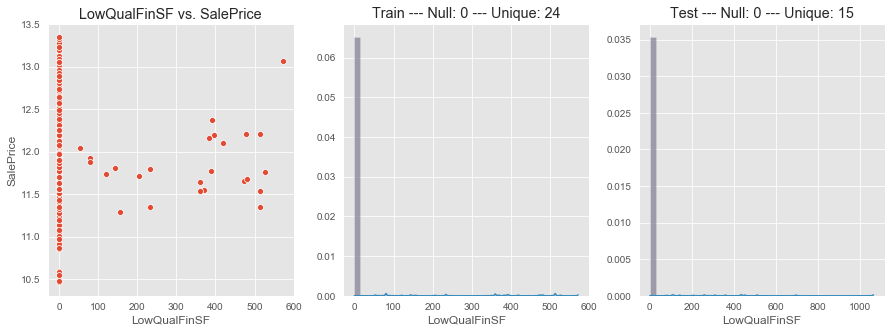

count    1455.000000
mean     5.864605   
std      48.705402  
min      0.000000   
25%      0.000000   
50%      0.000000   
75%      0.000000   
max      572.000000 
Name: LowQualFinSF, dtype: float64
------------------------------------------------------------------------------------------------------------------------


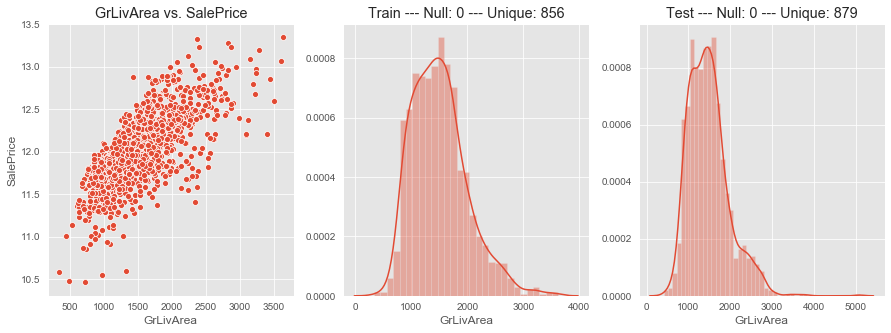

count    1455.000000
mean     1506.115464
std      496.767066 
min      334.000000 
25%      1128.000000
50%      1458.000000
75%      1774.500000
max      3627.000000
Name: GrLivArea, dtype: float64
------------------------------------------------------------------------------------------------------------------------


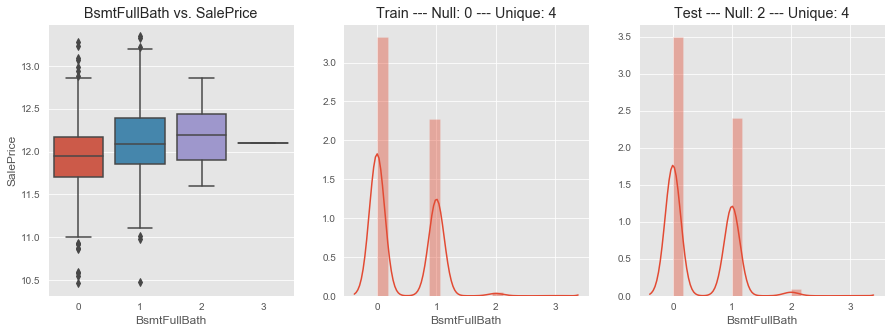

count    1455.000000
mean     0.423368   
std      0.517377   
min      0.000000   
25%      0.000000   
50%      0.000000   
75%      1.000000   
max      3.000000   
Name: BsmtFullBath, dtype: float64
------------------------------------------------------------------------------------------------------------------------


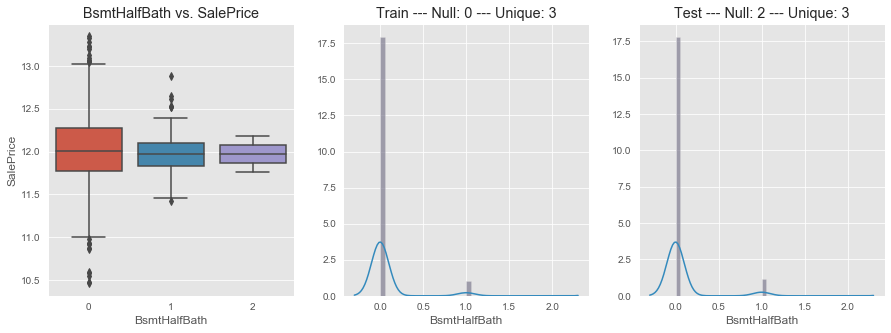

count    1455.000000
mean     0.057045   
std      0.237863   
min      0.000000   
25%      0.000000   
50%      0.000000   
75%      0.000000   
max      2.000000   
Name: BsmtHalfBath, dtype: float64
------------------------------------------------------------------------------------------------------------------------


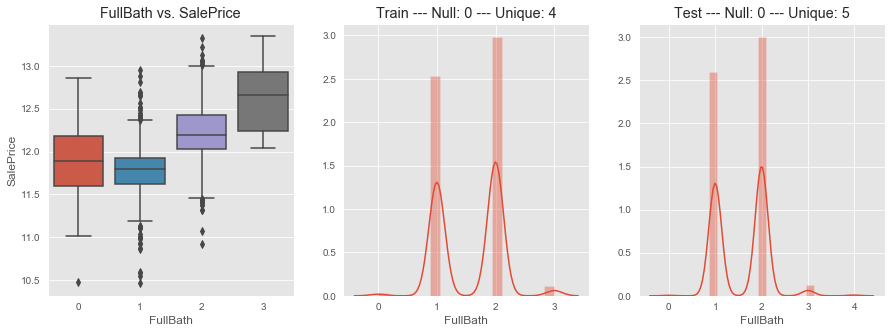

count    1455.000000
mean     1.561512   
std      0.547751   
min      0.000000   
25%      1.000000   
50%      2.000000   
75%      2.000000   
max      3.000000   
Name: FullBath, dtype: float64
------------------------------------------------------------------------------------------------------------------------


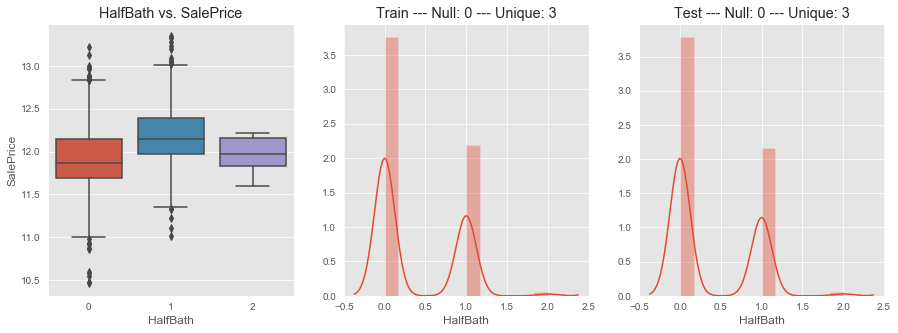

count    1455.000000
mean     0.381443   
std      0.502606   
min      0.000000   
25%      0.000000   
50%      0.000000   
75%      1.000000   
max      2.000000   
Name: HalfBath, dtype: float64
------------------------------------------------------------------------------------------------------------------------


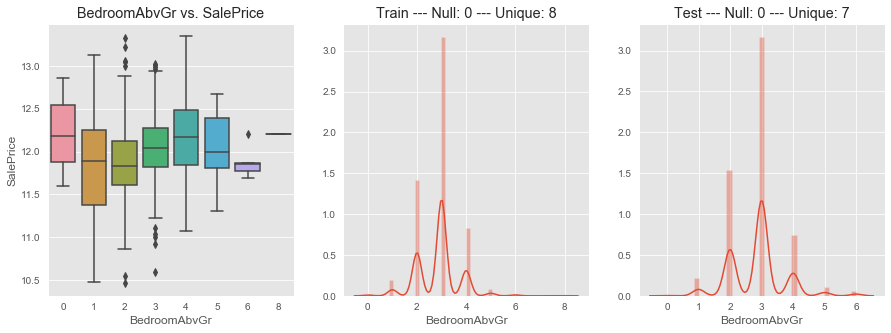

count    1455.000000
mean     2.863918   
std      0.815537   
min      0.000000   
25%      2.000000   
50%      3.000000   
75%      3.000000   
max      8.000000   
Name: BedroomAbvGr, dtype: float64
------------------------------------------------------------------------------------------------------------------------


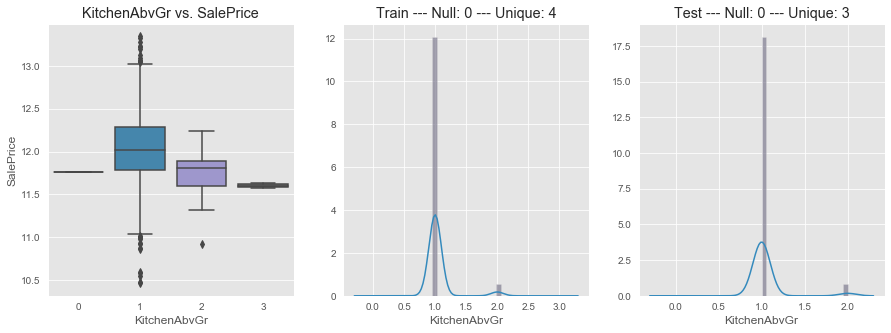

count    1455.000000
mean     1.046735   
std      0.220700   
min      0.000000   
25%      1.000000   
50%      1.000000   
75%      1.000000   
max      3.000000   
Name: KitchenAbvGr, dtype: float64
------------------------------------------------------------------------------------------------------------------------


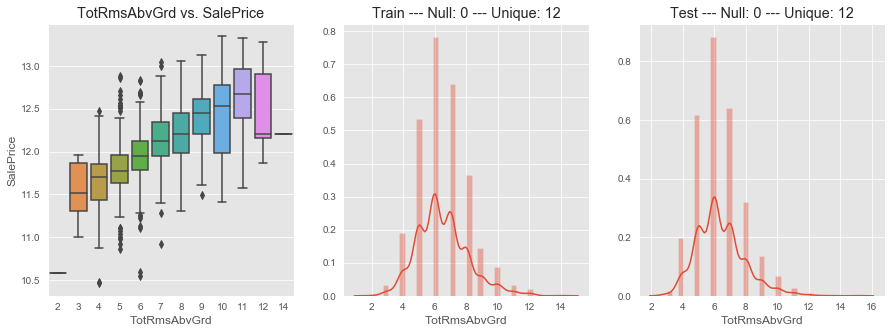

count    1455.000000
mean     6.504467   
std      1.611027   
min      2.000000   
25%      5.000000   
50%      6.000000   
75%      7.000000   
max      14.000000  
Name: TotRmsAbvGrd, dtype: float64
------------------------------------------------------------------------------------------------------------------------


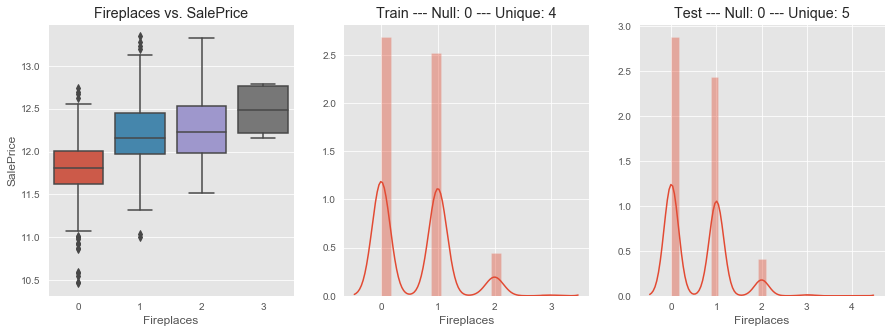

count    1455.000000
mean     0.608935   
std      0.640497   
min      0.000000   
25%      0.000000   
50%      1.000000   
75%      1.000000   
max      3.000000   
Name: Fireplaces, dtype: float64
------------------------------------------------------------------------------------------------------------------------


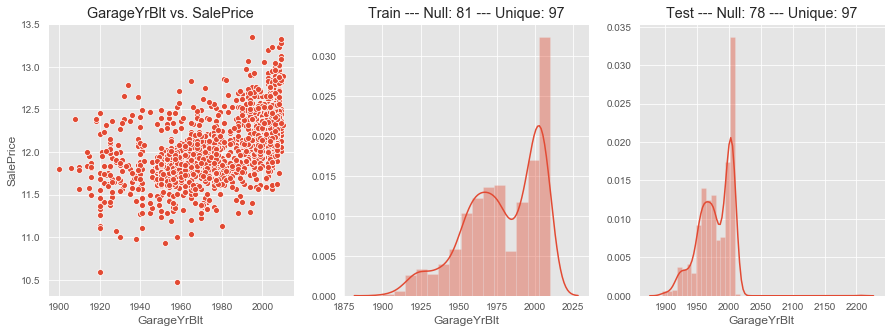

count    1374.000000
mean     1978.453421
std      24.696711  
min      1900.000000
25%      1961.000000
50%      1980.000000
75%      2002.000000
max      2010.000000
Name: GarageYrBlt, dtype: float64
------------------------------------------------------------------------------------------------------------------------


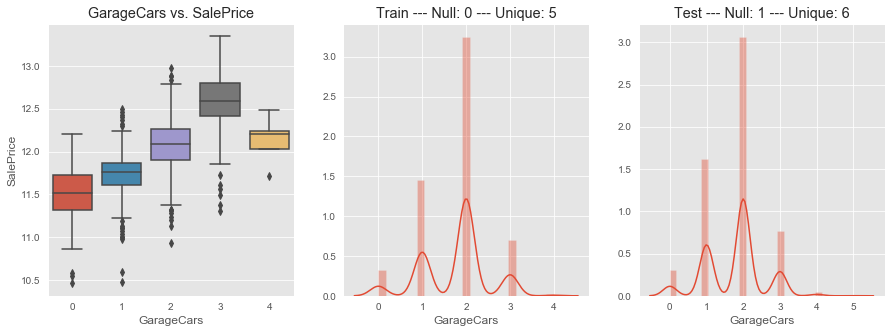

count    1455.000000
mean     1.764261   
std      0.746446   
min      0.000000   
25%      1.000000   
50%      2.000000   
75%      2.000000   
max      4.000000   
Name: GarageCars, dtype: float64
------------------------------------------------------------------------------------------------------------------------


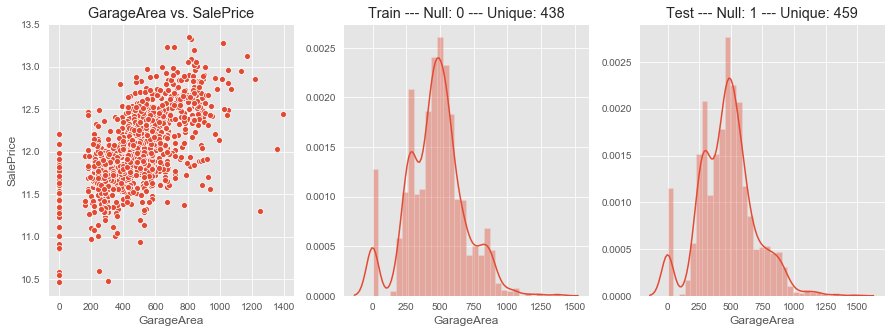

count    1455.000000
mean     471.545704 
std      212.057493 
min      0.000000   
25%      329.000000 
50%      478.000000 
75%      576.000000 
max      1390.000000
Name: GarageArea, dtype: float64
------------------------------------------------------------------------------------------------------------------------


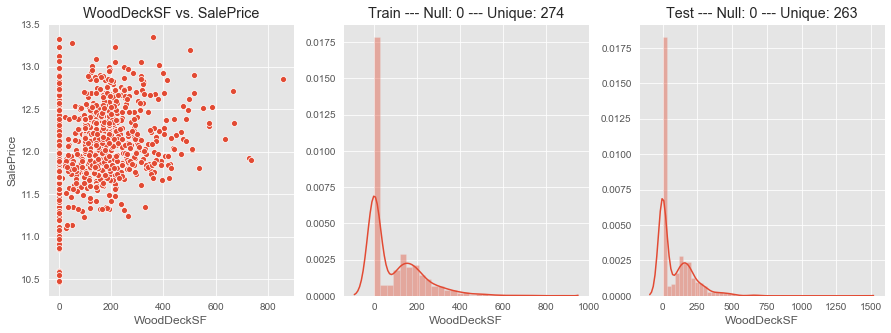

count    1455.000000
mean     93.898282  
std      125.211197 
min      0.000000   
25%      0.000000   
50%      0.000000   
75%      168.000000 
max      857.000000 
Name: WoodDeckSF, dtype: float64
------------------------------------------------------------------------------------------------------------------------


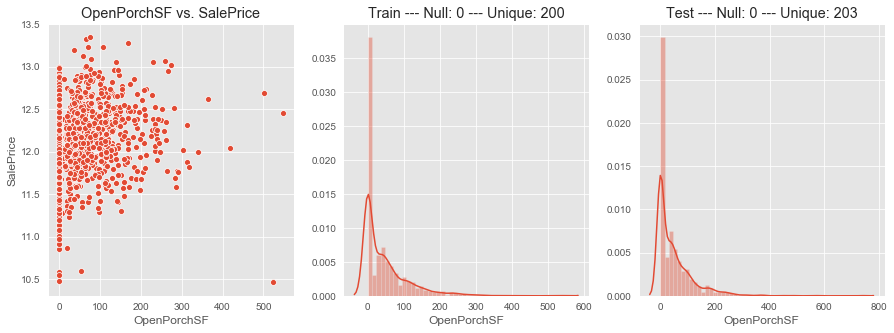

count    1455.000000
mean     46.252921  
std      65.363647  
min      0.000000   
25%      0.000000   
50%      24.000000  
75%      68.000000  
max      547.000000 
Name: OpenPorchSF, dtype: float64
------------------------------------------------------------------------------------------------------------------------


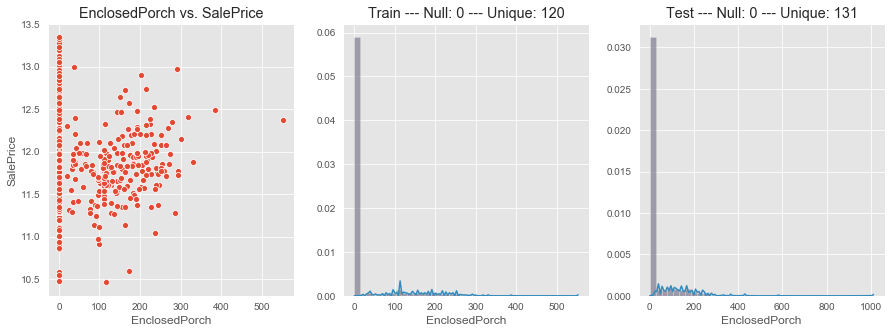

count    1455.000000
mean     22.029553  
std      61.210563  
min      0.000000   
25%      0.000000   
50%      0.000000   
75%      0.000000   
max      552.000000 
Name: EnclosedPorch, dtype: float64
------------------------------------------------------------------------------------------------------------------------


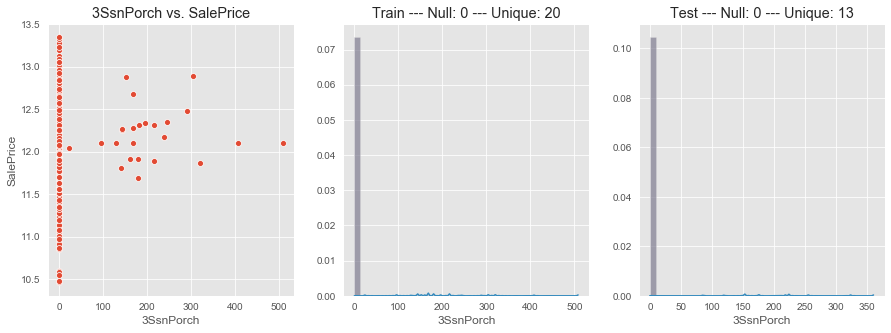

count    1455.000000
mean     3.421306   
std      29.367012  
min      0.000000   
25%      0.000000   
50%      0.000000   
75%      0.000000   
max      508.000000 
Name: 3SsnPorch, dtype: float64
------------------------------------------------------------------------------------------------------------------------


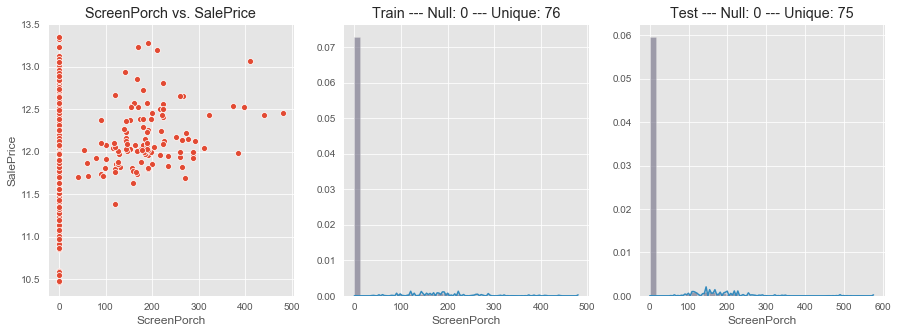

count    1455.000000
mean     15.112715  
std      55.846195  
min      0.000000   
25%      0.000000   
50%      0.000000   
75%      0.000000   
max      480.000000 
Name: ScreenPorch, dtype: float64
------------------------------------------------------------------------------------------------------------------------


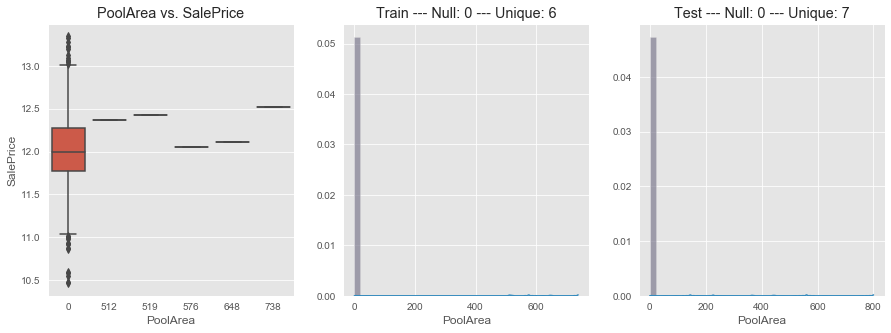

count    1455.000000
mean     2.057045   
std      35.395897  
min      0.000000   
25%      0.000000   
50%      0.000000   
75%      0.000000   
max      738.000000 
Name: PoolArea, dtype: float64
------------------------------------------------------------------------------------------------------------------------


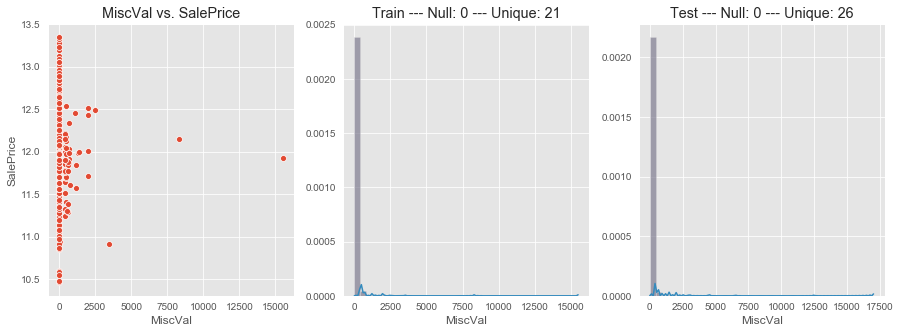

count    1455.000000 
mean     43.638488   
std      496.968758  
min      0.000000    
25%      0.000000    
50%      0.000000    
75%      0.000000    
max      15500.000000
Name: MiscVal, dtype: float64
------------------------------------------------------------------------------------------------------------------------


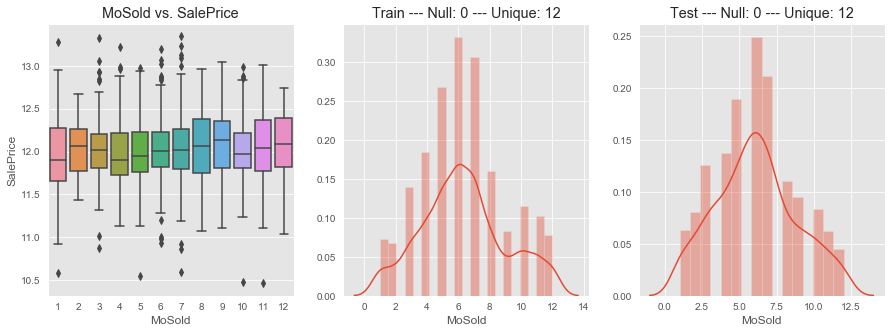

count    1455.000000
mean     6.323024   
std      2.696498   
min      1.000000   
25%      5.000000   
50%      6.000000   
75%      8.000000   
max      12.000000  
Name: MoSold, dtype: float64
------------------------------------------------------------------------------------------------------------------------


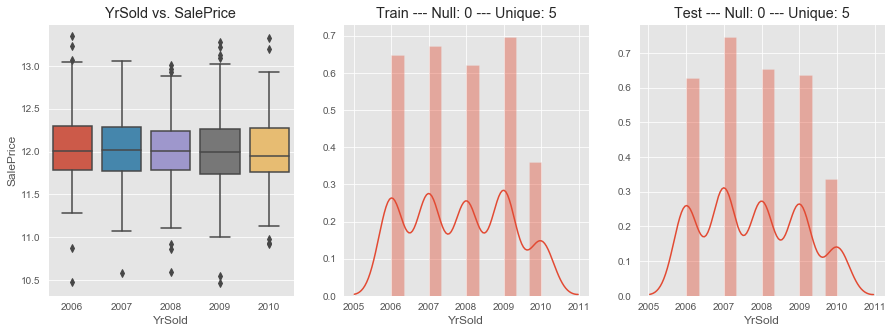

count    1455.000000
mean     2007.817182
std      1.329842   
min      2006.000000
25%      2007.000000
50%      2008.000000
75%      2009.000000
max      2010.000000
Name: YrSold, dtype: float64
------------------------------------------------------------------------------------------------------------------------


In [31]:
num_col_visualizer(train, test, num_cols, target, box_limit=12)

In [ ]:
str_col_visualizer(train, test, num_cols, target, box_limit=12)

In [38]:
def str_col_visualizer(train, test, str_cols, target, box_limit=10):

    for col in str_cols:

        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5) )
        # plt.suptitle(col, fontsize=20)

        ## FIRST SUBPLOT
        sns.boxplot(data=train,  x=col, y=target, ax=ax1)
        ax1.set( title = col + ' vs. ' + target ) 

        ## SECOND SUBPLOT
        h = train[col].value_counts()
        sns.barplot(x=h.index, y=h.values, ax=ax2)
        ax2.set( title = 'Train --- Null: ' + str(train[col].isnull().sum()) + ' --- Unique: ' + str( train[col].nunique()  ) )

        ## THIRD SUBPLOT
        g = test[col].value_counts()
        sns.barplot(x=g.index, y=g.values, ax=ax3)
        ax3.set( title = 'Test --- Null: ' + str(test[col].isnull().sum())  + ' --- Unique: ' + str( test[col].nunique() ) )

        plt.show()
        print(train[col].describe(include='all'))
        print('-'*120)  

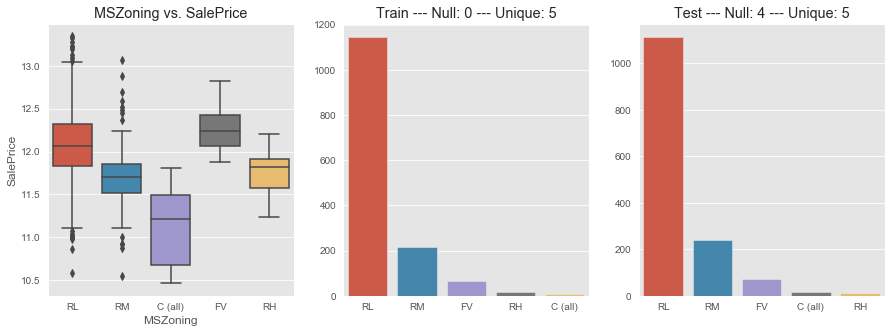

count     1455
unique    5   
top       RL  
freq      1146
Name: MSZoning, dtype: object
------------------------------------------------------------------------------------------------------------------------


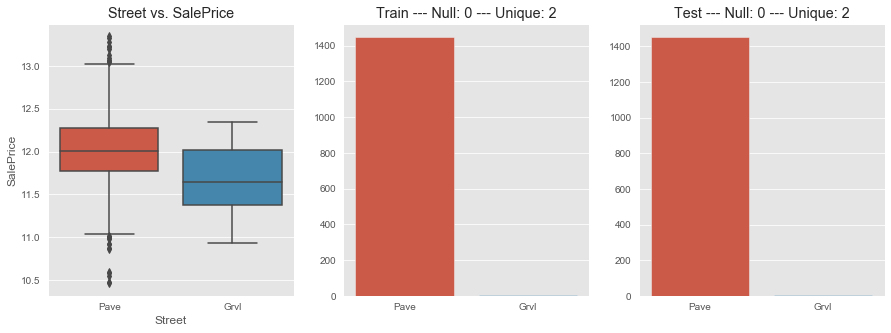

count     1455
unique    2   
top       Pave
freq      1449
Name: Street, dtype: object
------------------------------------------------------------------------------------------------------------------------


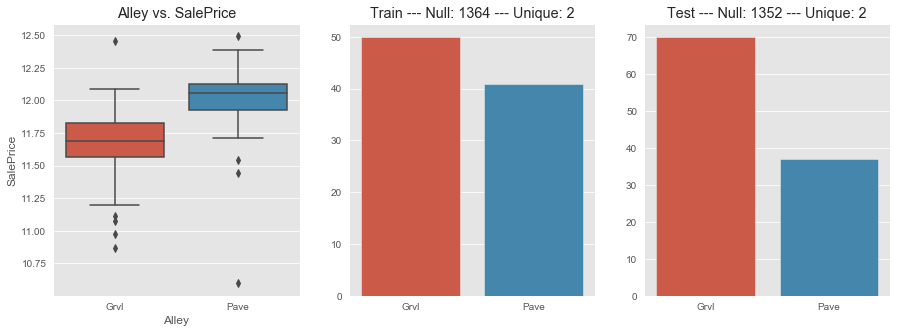

count     91  
unique    2   
top       Grvl
freq      50  
Name: Alley, dtype: object
------------------------------------------------------------------------------------------------------------------------


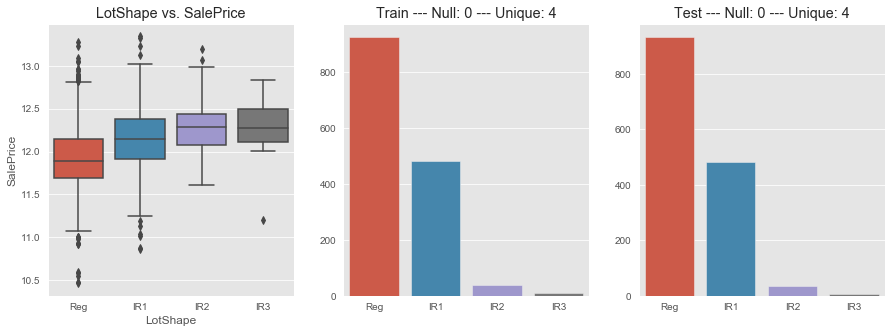

count     1455
unique    4   
top       Reg 
freq      925 
Name: LotShape, dtype: object
------------------------------------------------------------------------------------------------------------------------


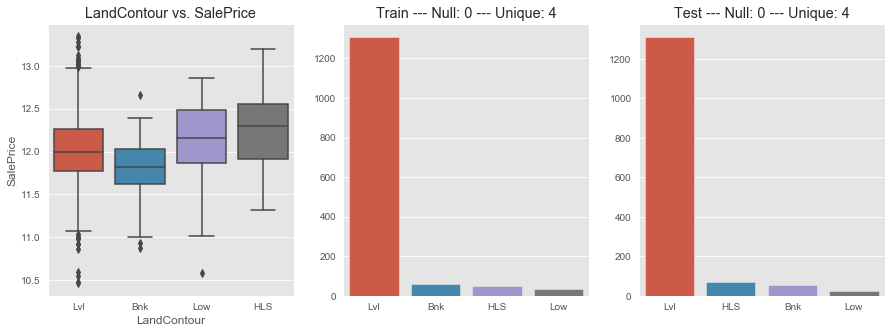

count     1455
unique    4   
top       Lvl 
freq      1309
Name: LandContour, dtype: object
------------------------------------------------------------------------------------------------------------------------


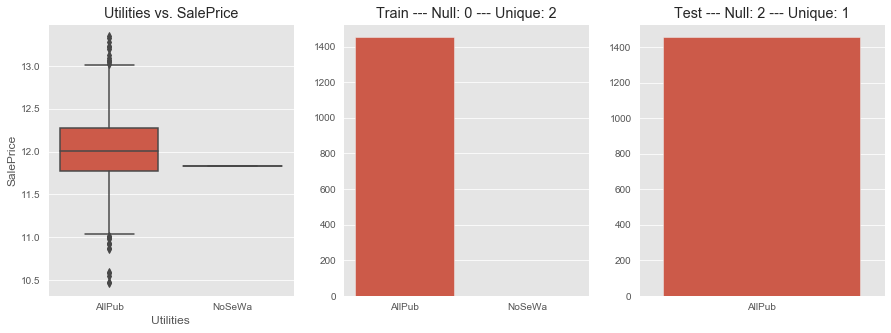

count     1455  
unique    2     
top       AllPub
freq      1454  
Name: Utilities, dtype: object
------------------------------------------------------------------------------------------------------------------------


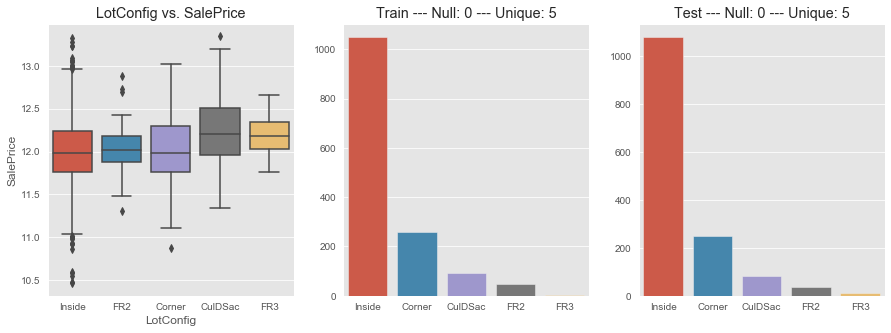

count     1455  
unique    5     
top       Inside
freq      1050  
Name: LotConfig, dtype: object
------------------------------------------------------------------------------------------------------------------------


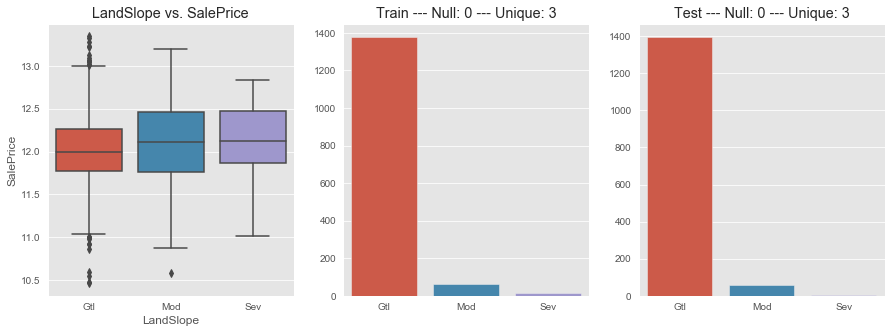

count     1455
unique    3   
top       Gtl 
freq      1378
Name: LandSlope, dtype: object
------------------------------------------------------------------------------------------------------------------------


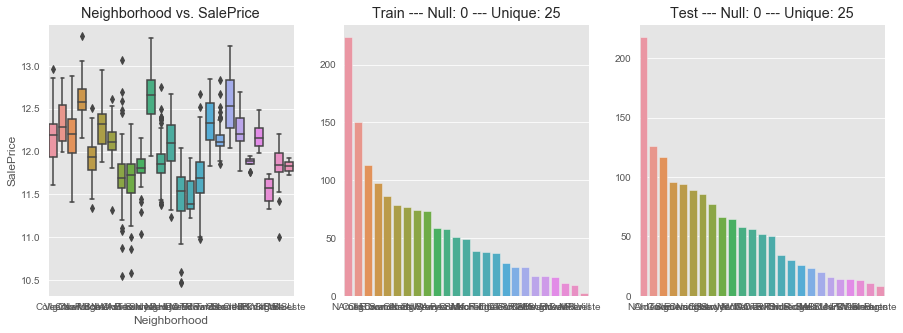

count     1455 
unique    25   
top       NAmes
freq      224  
Name: Neighborhood, dtype: object
------------------------------------------------------------------------------------------------------------------------


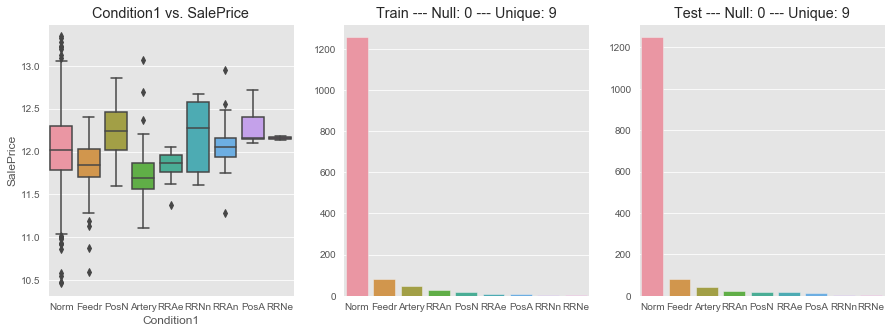

count     1455
unique    9   
top       Norm
freq      1258
Name: Condition1, dtype: object
------------------------------------------------------------------------------------------------------------------------


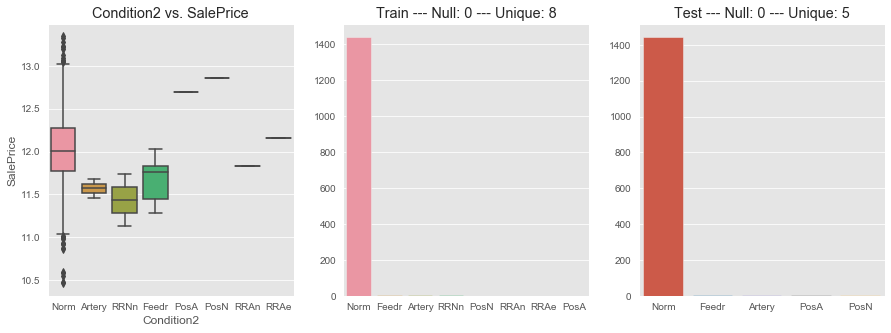

count     1455
unique    8   
top       Norm
freq      1441
Name: Condition2, dtype: object
------------------------------------------------------------------------------------------------------------------------


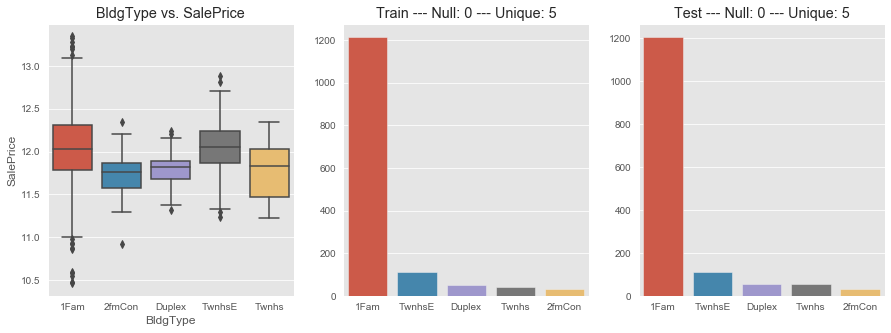

count     1455
unique    5   
top       1Fam
freq      1215
Name: BldgType, dtype: object
------------------------------------------------------------------------------------------------------------------------


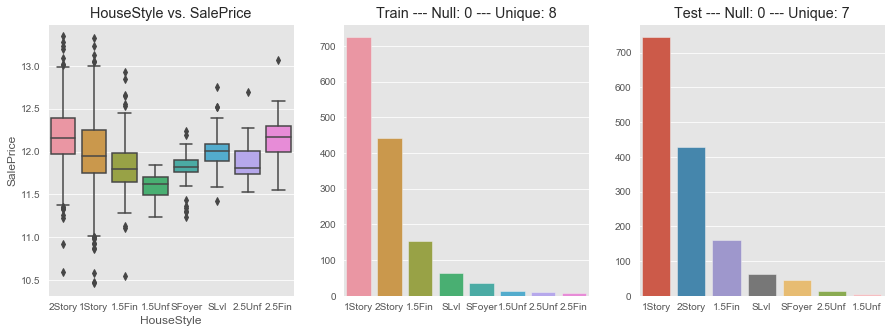

count     1455  
unique    8     
top       1Story
freq      725   
Name: HouseStyle, dtype: object
------------------------------------------------------------------------------------------------------------------------


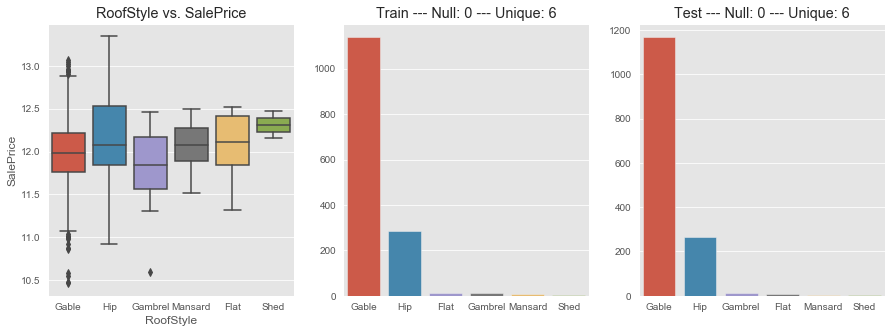

count     1455 
unique    6    
top       Gable
freq      1140 
Name: RoofStyle, dtype: object
------------------------------------------------------------------------------------------------------------------------


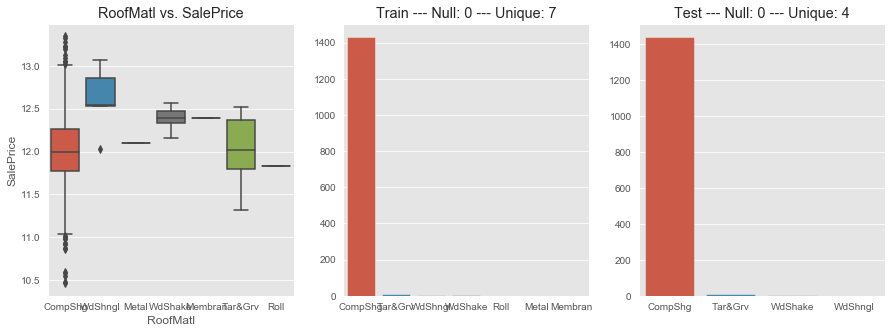

count     1455   
unique    7      
top       CompShg
freq      1432   
Name: RoofMatl, dtype: object
------------------------------------------------------------------------------------------------------------------------


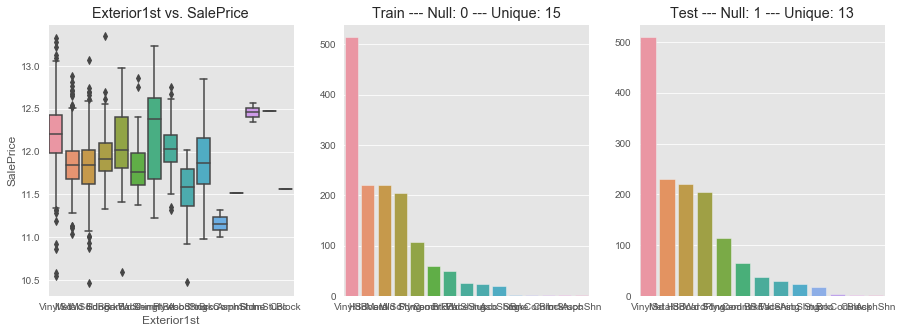

count     1455   
unique    15     
top       VinylSd
freq      515    
Name: Exterior1st, dtype: object
------------------------------------------------------------------------------------------------------------------------


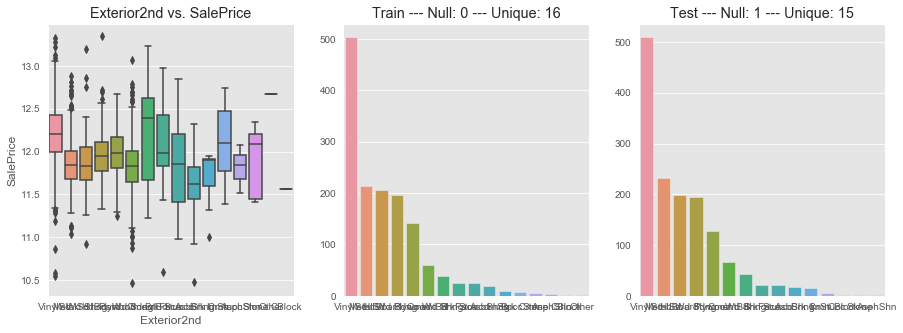

count     1455   
unique    16     
top       VinylSd
freq      504    
Name: Exterior2nd, dtype: object
------------------------------------------------------------------------------------------------------------------------


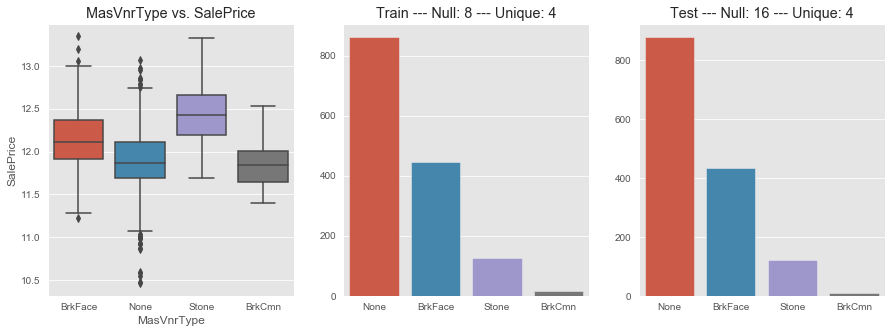

count     1447
unique    4   
top       None
freq      862 
Name: MasVnrType, dtype: object
------------------------------------------------------------------------------------------------------------------------


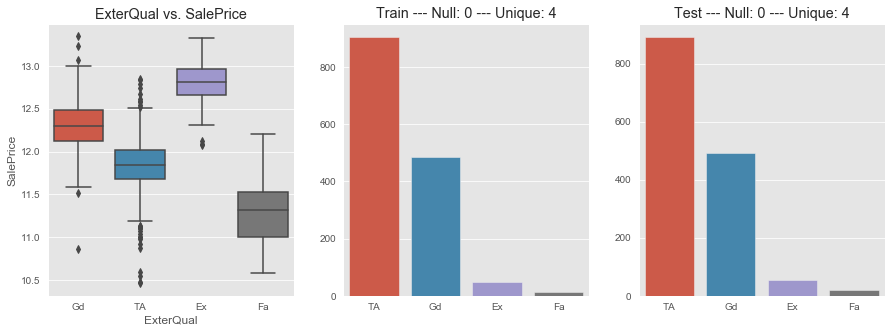

count     1455
unique    4   
top       TA  
freq      905 
Name: ExterQual, dtype: object
------------------------------------------------------------------------------------------------------------------------


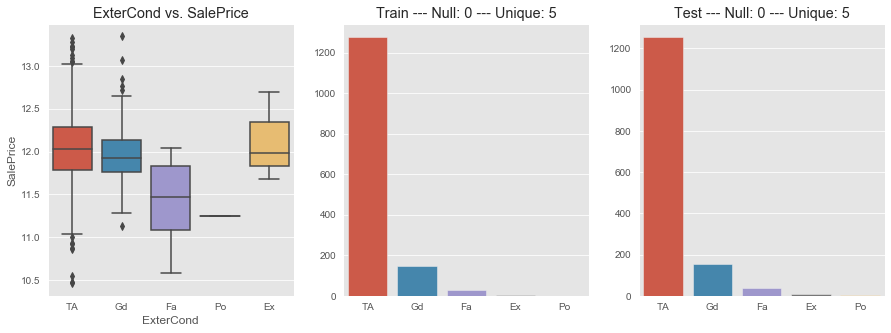

count     1455
unique    5   
top       TA  
freq      1277
Name: ExterCond, dtype: object
------------------------------------------------------------------------------------------------------------------------


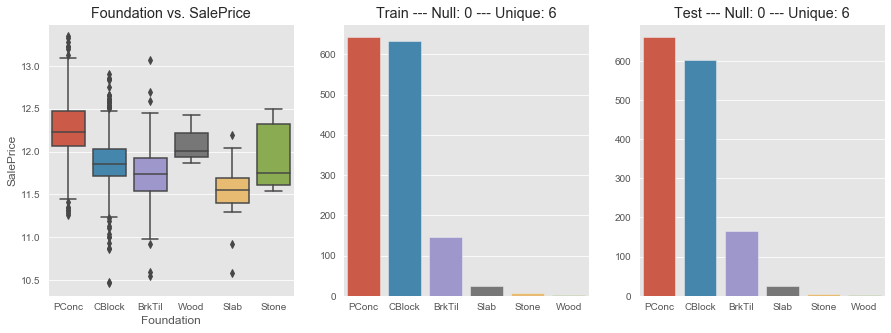

count     1455 
unique    6    
top       PConc
freq      643  
Name: Foundation, dtype: object
------------------------------------------------------------------------------------------------------------------------


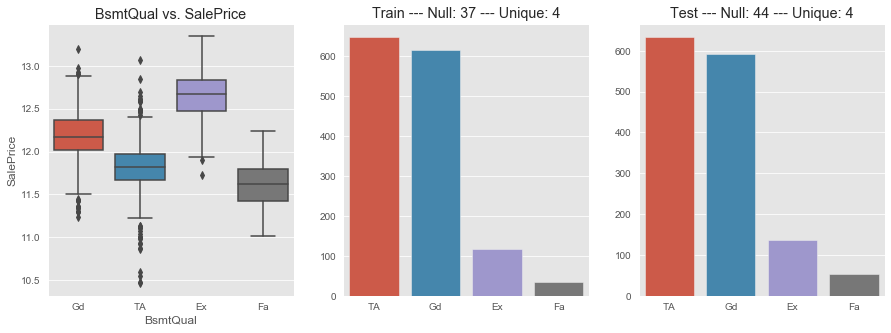

count     1418
unique    4   
top       TA  
freq      649 
Name: BsmtQual, dtype: object
------------------------------------------------------------------------------------------------------------------------


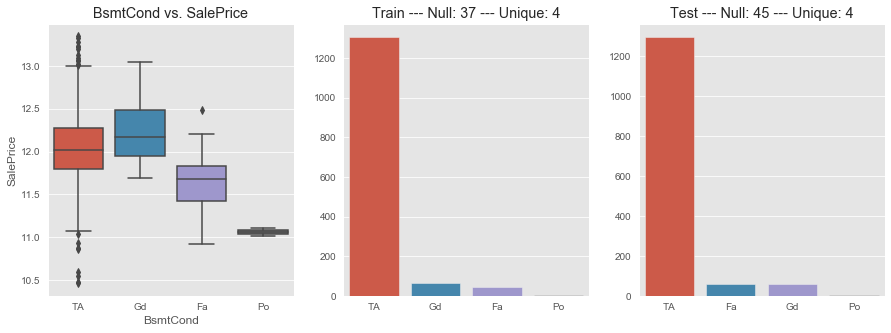

count     1418
unique    4   
top       TA  
freq      1306
Name: BsmtCond, dtype: object
------------------------------------------------------------------------------------------------------------------------


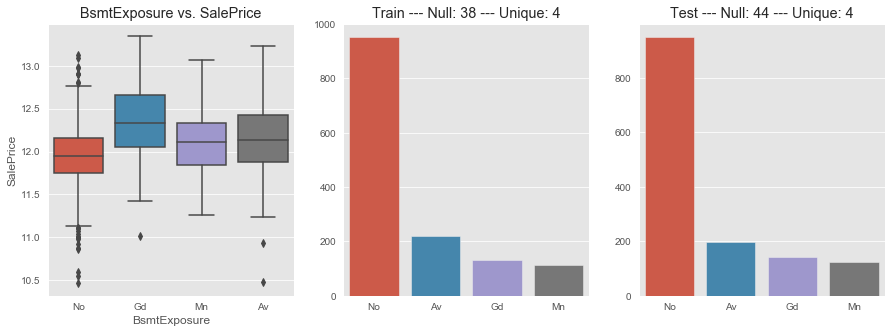

count     1417
unique    4   
top       No  
freq      953 
Name: BsmtExposure, dtype: object
------------------------------------------------------------------------------------------------------------------------


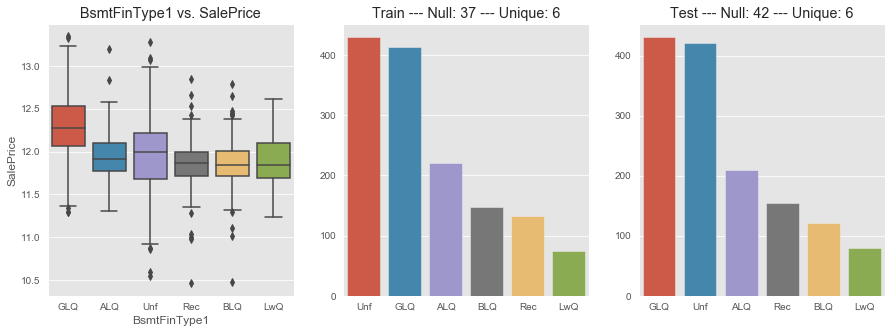

count     1418
unique    6   
top       Unf 
freq      430 
Name: BsmtFinType1, dtype: object
------------------------------------------------------------------------------------------------------------------------


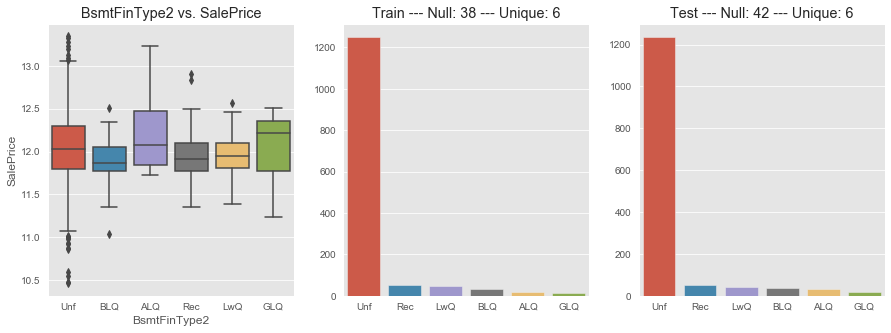

count     1417
unique    6   
top       Unf 
freq      1251
Name: BsmtFinType2, dtype: object
------------------------------------------------------------------------------------------------------------------------


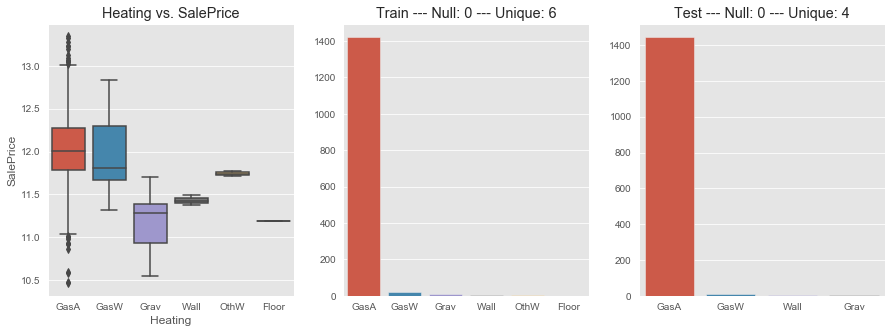

count     1455
unique    6   
top       GasA
freq      1423
Name: Heating, dtype: object
------------------------------------------------------------------------------------------------------------------------


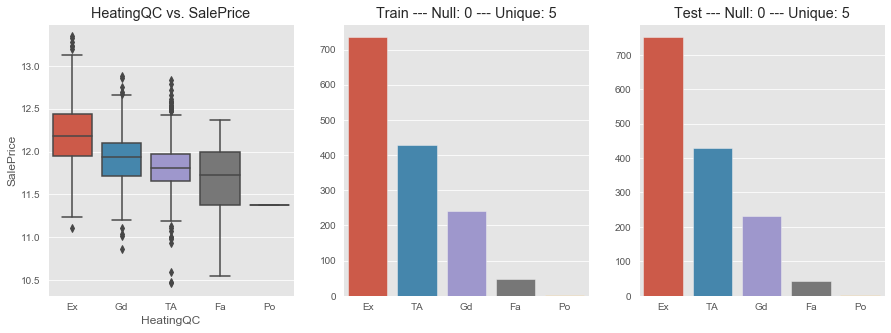

count     1455
unique    5   
top       Ex  
freq      736 
Name: HeatingQC, dtype: object
------------------------------------------------------------------------------------------------------------------------


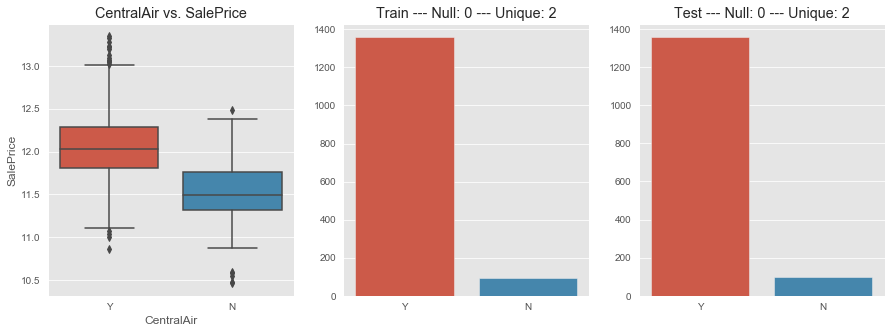

count     1455
unique    2   
top       Y   
freq      1360
Name: CentralAir, dtype: object
------------------------------------------------------------------------------------------------------------------------


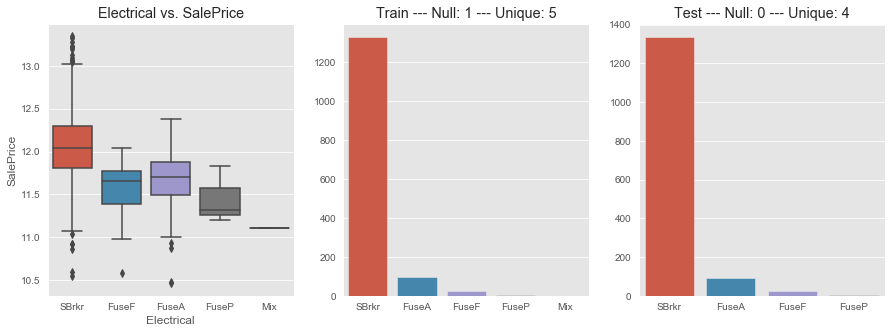

count     1454 
unique    5    
top       SBrkr
freq      1329 
Name: Electrical, dtype: object
------------------------------------------------------------------------------------------------------------------------


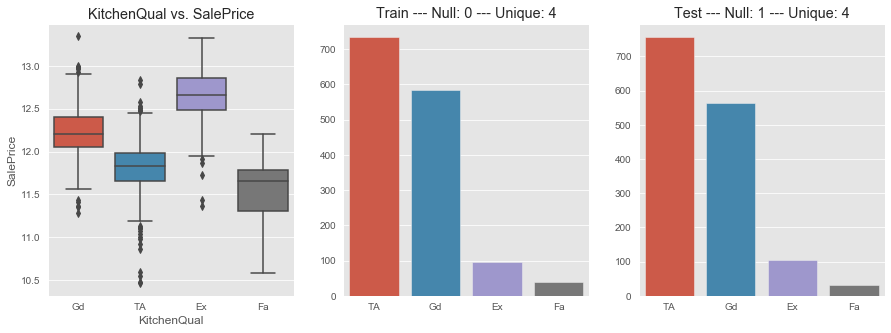

count     1455
unique    4   
top       TA  
freq      735 
Name: KitchenQual, dtype: object
------------------------------------------------------------------------------------------------------------------------


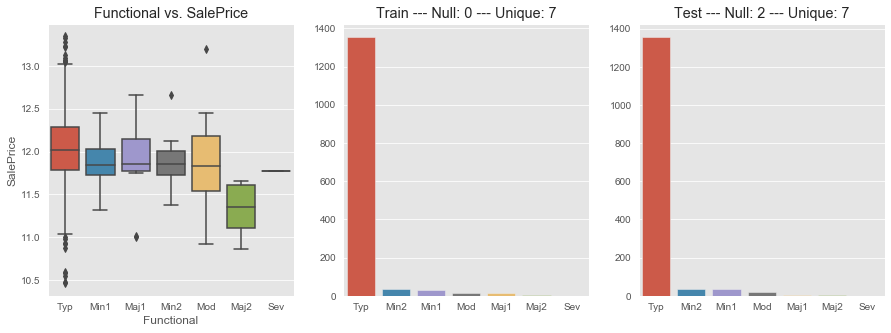

count     1455
unique    7   
top       Typ 
freq      1355
Name: Functional, dtype: object
------------------------------------------------------------------------------------------------------------------------


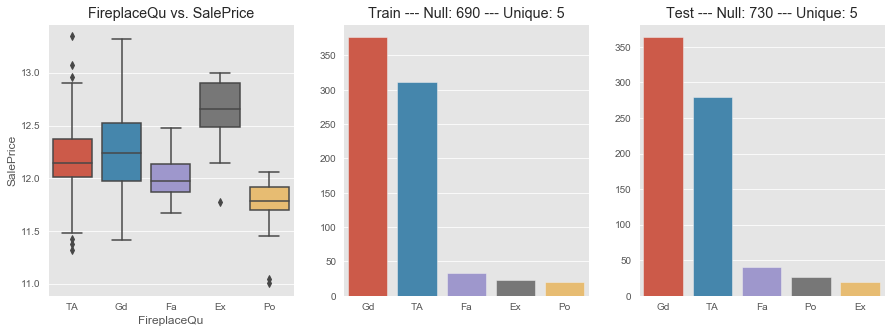

count     765
unique    5  
top       Gd 
freq      377
Name: FireplaceQu, dtype: object
------------------------------------------------------------------------------------------------------------------------


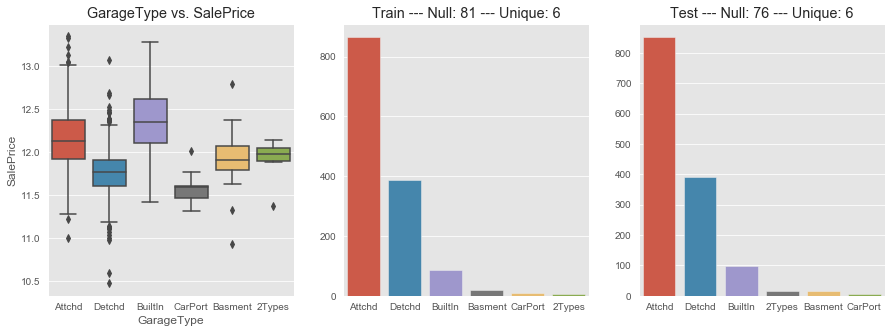

count     1374  
unique    6     
top       Attchd
freq      866   
Name: GarageType, dtype: object
------------------------------------------------------------------------------------------------------------------------


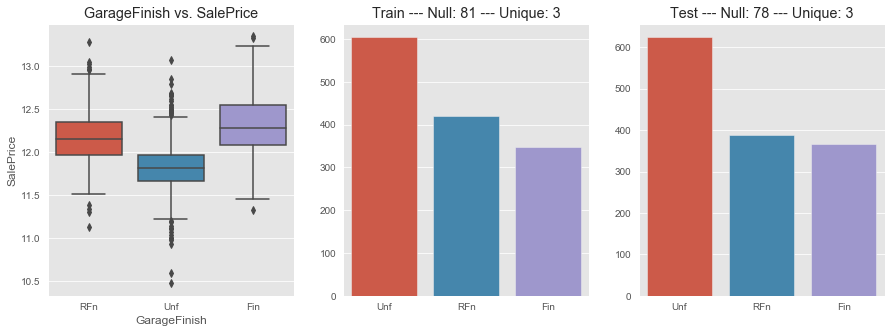

count     1374
unique    3   
top       Unf 
freq      605 
Name: GarageFinish, dtype: object
------------------------------------------------------------------------------------------------------------------------


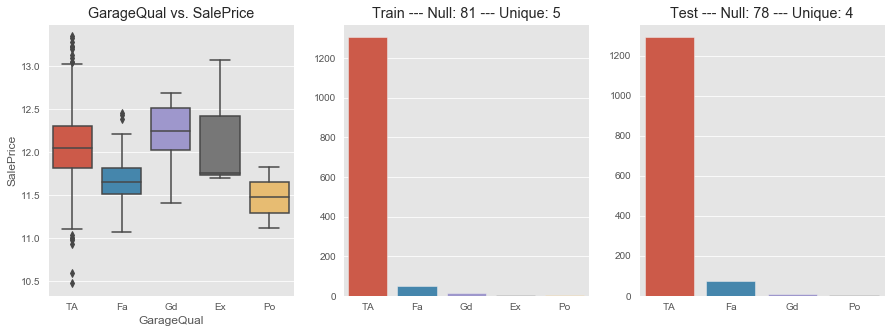

count     1374
unique    5   
top       TA  
freq      1306
Name: GarageQual, dtype: object
------------------------------------------------------------------------------------------------------------------------


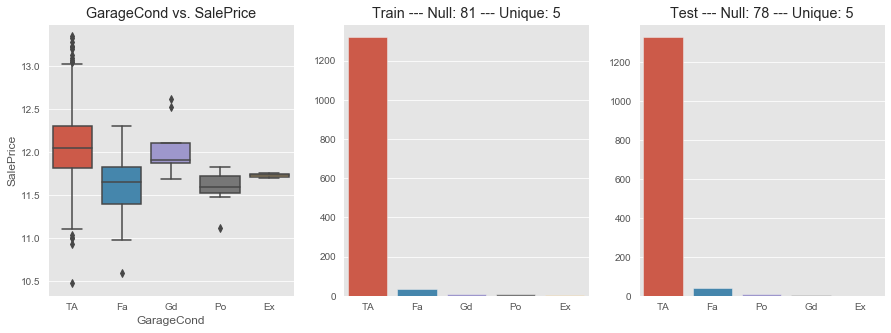

count     1374
unique    5   
top       TA  
freq      1321
Name: GarageCond, dtype: object
------------------------------------------------------------------------------------------------------------------------


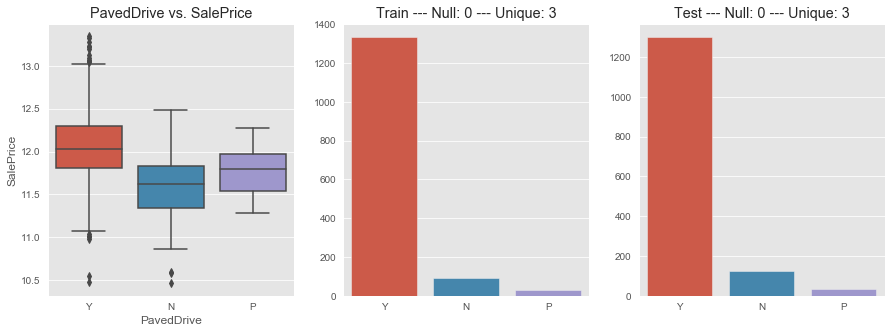

count     1455
unique    3   
top       Y   
freq      1335
Name: PavedDrive, dtype: object
------------------------------------------------------------------------------------------------------------------------


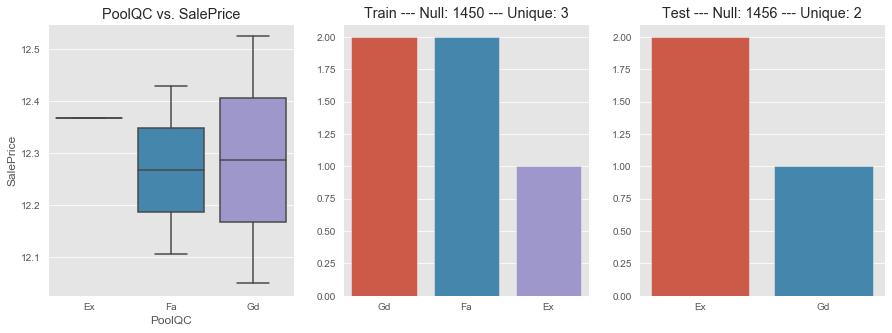

count     5 
unique    3 
top       Gd
freq      2 
Name: PoolQC, dtype: object
------------------------------------------------------------------------------------------------------------------------


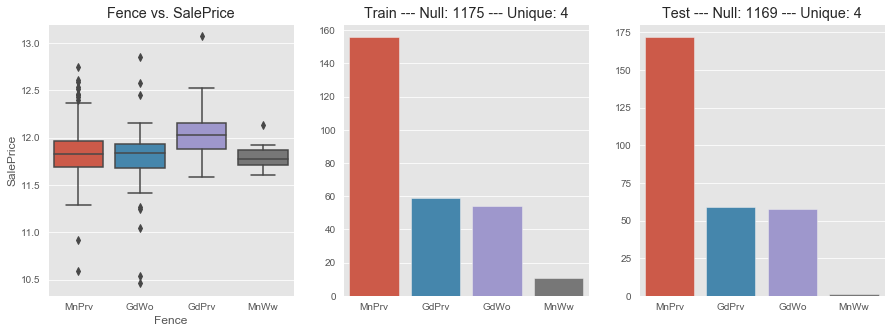

count     280  
unique    4    
top       MnPrv
freq      156  
Name: Fence, dtype: object
------------------------------------------------------------------------------------------------------------------------


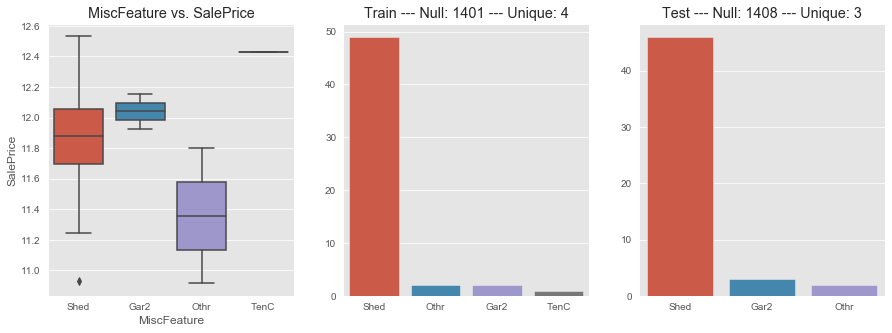

count     54  
unique    4   
top       Shed
freq      49  
Name: MiscFeature, dtype: object
------------------------------------------------------------------------------------------------------------------------


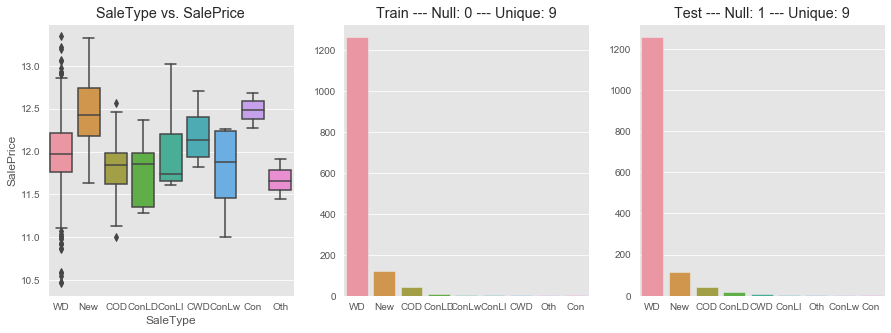

count     1455
unique    9   
top       WD  
freq      1264
Name: SaleType, dtype: object
------------------------------------------------------------------------------------------------------------------------


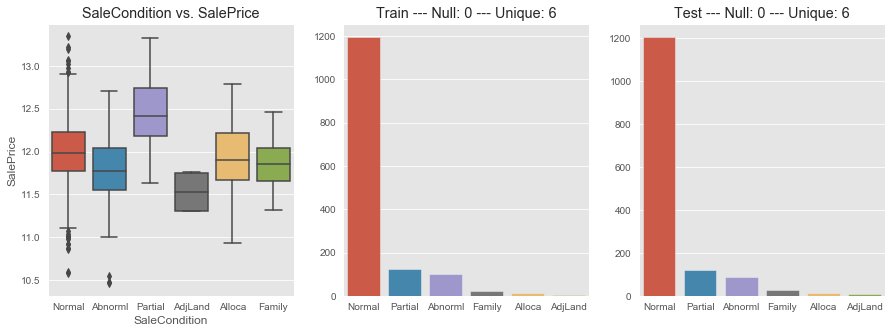

count     1455  
unique    6     
top       Normal
freq      1196  
Name: SaleCondition, dtype: object
------------------------------------------------------------------------------------------------------------------------


In [39]:
str_col_visualizer(train, test, str_cols, target, box_limit=12)

## DETECTION OF NULL VALUES

In [ ]:
null_detector(train)

In [ ]:
null_detector( test )

## 2. BASIC PREPROCESSING

### 2.1. TRAIN DATA PREPARATION

In [ ]:
print(train.shape)
print('-'*25)
train.head()

In [ ]:
train['id'] = train['item_id'] + '_' + train['store_id']
print(train.shape)
print('-'*25)
train.head()

In [ ]:
# Making data usable in models
with timer():
    train = pd.melt( train,
                     id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], 
                     value_vars = [col for col in train.columns if col.startswith("d_")],
                     var_name = "d",
                     value_name = "sales")
with timer():
    train['d']     = train['d'].str.extract('(\d+)').astype('int16')
    train['sales'] = train['sales'].astype('int16')


with timer():
    train.sort_values(['id', 'd'], inplace=True)


print(train.shape)
print('-'*25)
train.tail()

In [ ]:
# Adding the 28 days we try to forecast
with timer():
    tmp = train.groupby('id', as_index=False ).tail(28)
    tmp['d'] = tmp['d'] + 28
    tmp['sales'] = np.nan
    print(tmp.shape)

with timer():
    train = pd.concat([train,tmp], axis=0, sort=False, ignore_index=True)

del tmp; gc.collect()

with timer():
    train.sort_values(['id', 'd'], inplace=True)
    train.reset_index(drop=True, inplace=True)
    
print(train.shape)
print('-'*25)
train.tail()

In [ ]:
## Adding lag days
def lagger(train, lag_day):
    train[f'sales_lag_{lag_day}'] = train[['id', 'd', 'sales']].groupby('id')['sales'].transform( lambda x: x.shift(lag_day) ).astype('float16')
    return train

In [ ]:
for i in [1,2,3,4,5,6,7,8,12,13,14,15,28]:
    train = lagger(train,i)
    print(i, 'DONE')

In [ ]:
print(train.shape)
print('-'*25)
train.tail()

### 2.2. CALENDAR DATA PREPARATION

In [ ]:
print(calendar.shape)
print('-'*25)
calendar.tail()

In [ ]:
with timer():
    calendar['d'] = calendar['d'].str.extract('(\d+)').astype('int16')
    
    calendar['day'] = pd.to_datetime(calendar['date']).dt.day
    
    for col in ['wday', 'month', 'wm_yr_wk', 'year']:
        calendar[col] = calendar[col].astype('int16')
    
    calendar.drop(['date', 'weekday'], axis=1, inplace=True)
        
print(calendar.shape)
print('-'*25)
calendar.tail()

In [ ]:
## DO NOT FORGET TO ADD SNAP DATA
snap = calendar[['d', 'snap_CA', 'snap_TX', 'snap_WI']]

snap = pd.melt( snap,
                     id_vars = ['d'],
                     value_vars = [col for col in snap.columns if col.startswith("snap_")],
                     var_name = "state_id",
                     value_name = "is_snap")

snap['state_id'] = snap['state_id'].str[5:].astype('category')
snap['is_snap'] = snap['is_snap'].astype('int8')

print(snap.shape)
print('-'*25)
snap.tail()

In [ ]:
calendar.drop(['snap_CA', 'snap_TX', 'snap_WI'], axis=1, inplace=True)

In [ ]:
tmp = pd.get_dummies(calendar['event_name_1'], dtype ='int8' )
calendar = pd.concat([calendar, tmp], axis=1)

tmp = pd.get_dummies(calendar['event_type_1'], dtype ='int8' )
calendar = pd.concat([calendar, tmp], axis=1)


tmp = pd.get_dummies(calendar['event_name_2'], prefix = '2', dtype ='int8' )
calendar = pd.concat([calendar, tmp], axis=1)

tmp = pd.get_dummies(calendar['event_type_2'], prefix = '2', dtype ='int8' )
calendar = pd.concat([calendar, tmp], axis=1)

calendar.drop(['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2'], axis=1, inplace=True)
del tmp; gc.collect()

print(calendar.shape)
print('-'*25)
calendar.tail(5)

In [ ]:
calendar['Cinco De Mayo']    = calendar['Cinco De Mayo']   + calendar['2_Cinco De Mayo']
calendar['Easter']           = calendar['Easter']          + calendar['2_Easter']
calendar['Father\'s day']    = calendar['Father\'s day']   + calendar['2_Father\'s day']
calendar['OrthodoxEaster']   = calendar['OrthodoxEaster']  + calendar['2_OrthodoxEaster']
calendar['Cultural']         = calendar['Cultural']        + calendar['2_Cultural']
calendar['Religious']        = calendar['Religious']       + calendar['2_Religious']

calendar.drop([col for col in calendar.columns if col.startswith('2_')], axis=1, inplace=True)

print(calendar.shape)
print('-'*25)
calendar.tail(5)

In [ ]:
calendar.loc[ (calendar['d'] >= 185 )  & ( calendar['d'] < 185 + 29 ), 'Ramadan starts' ]  = 1
calendar.loc[ (calendar['d'] >= 539 )  & ( calendar['d'] < 539 + 29 ), 'Ramadan starts' ]  = 1
calendar.loc[ (calendar['d'] >= 893 )  & ( calendar['d'] < 893 + 29 ), 'Ramadan starts' ]  = 1
calendar.loc[ (calendar['d'] >= 1248)  & ( calendar['d'] < 1248 + 29), 'Ramadan starts' ]  = 1
calendar.loc[ (calendar['d'] >= 1602)  & ( calendar['d'] < 1602 + 29), 'Ramadan starts' ]  = 1
calendar.loc[ (calendar['d'] >= 1957)                                , 'Ramadan starts' ]  = 1

calendar.loc[ (calendar['d'] >= 185 )  & ( calendar['d'] < 185 + 29 ), 'Religious' ]  = 1
calendar.loc[ (calendar['d'] >= 539 )  & ( calendar['d'] < 539 + 29 ), 'Religious' ]  = 1
calendar.loc[ (calendar['d'] >= 893 )  & ( calendar['d'] < 893 + 29 ), 'Religious' ]  = 1
calendar.loc[ (calendar['d'] >= 1248)  & ( calendar['d'] < 1248 + 29), 'Religious' ]  = 1
calendar.loc[ (calendar['d'] >= 1602)  & ( calendar['d'] < 1602 + 29), 'Religious' ]  = 1
calendar.loc[ (calendar['d'] >= 1957)                                , 'Religious' ]  = 1


In [ ]:
calendar.loc[ (calendar['d'] >= 215 - 1  )  & ( calendar['d'] <= 215 + 1  ), 'Eid al-Fitr' ]  = 1
calendar.loc[ (calendar['d'] >= 569 - 1  )  & ( calendar['d'] <= 569 + 1  ), 'Eid al-Fitr' ]  = 1
calendar.loc[ (calendar['d'] >= 923 - 1  )  & ( calendar['d'] <= 923 + 1  ), 'Eid al-Fitr' ]  = 1
calendar.loc[ (calendar['d'] >= 1278 - 1 )  & ( calendar['d'] <= 1278 + 1 ), 'Eid al-Fitr' ]  = 1
calendar.loc[ (calendar['d'] >= 1632 - 1 )  & ( calendar['d'] <= 1632 + 1 ), 'Eid al-Fitr' ]  = 1

calendar.loc[ (calendar['d'] >= 215 - 1  )  & ( calendar['d'] <= 215 + 1  ), 'Religious' ]  = 1
calendar.loc[ (calendar['d'] >= 569 - 1  )  & ( calendar['d'] <= 569 + 1  ), 'Religious' ]  = 1
calendar.loc[ (calendar['d'] >= 923 - 1  )  & ( calendar['d'] <= 923 + 1  ), 'Religious' ]  = 1
calendar.loc[ (calendar['d'] >= 1278 - 1 )  & ( calendar['d'] <= 1278 + 1 ), 'Religious' ]  = 1
calendar.loc[ (calendar['d'] >= 1632 - 1 )  & ( calendar['d'] <= 1632 + 1 ), 'Religious' ]  = 1

In [ ]:
calendar.loc[ (calendar['d'] >= 283   )  & ( calendar['d'] <= 283 + 3  ), 'EidAlAdha' ]  = 1
calendar.loc[ (calendar['d'] >= 637   )  & ( calendar['d'] <= 637 + 3  ), 'EidAlAdha' ]  = 1
calendar.loc[ (calendar['d'] >= 991   )  & ( calendar['d'] <= 991 + 3  ), 'EidAlAdha' ]  = 1
calendar.loc[ (calendar['d'] >= 1345  )  & ( calendar['d'] <= 1345 + 3 ), 'EidAlAdha' ]  = 1
calendar.loc[ (calendar['d'] >= 1700  )  & ( calendar['d'] <= 1700 + 3 ), 'EidAlAdha' ]  = 1

calendar.loc[ (calendar['d'] >= 283   )  & ( calendar['d'] <= 283 + 3  ), 'Religious' ]  = 1
calendar.loc[ (calendar['d'] >= 637   )  & ( calendar['d'] <= 637 + 3  ), 'Religious' ]  = 1
calendar.loc[ (calendar['d'] >= 991   )  & ( calendar['d'] <= 991 + 3  ), 'Religious' ]  = 1
calendar.loc[ (calendar['d'] >= 1345  )  & ( calendar['d'] <= 1345 + 3 ), 'Religious' ]  = 1
calendar.loc[ (calendar['d'] >= 1700  )  & ( calendar['d'] <= 1700 + 3 ), 'Religious' ]  = 1

In [ ]:
calendar.loc[ (calendar['d'] >= 123  )  & ( calendar['d'] <= 135  ), 'NBAFinalsStart' ]  = 1
calendar.loc[ (calendar['d'] >= 501  )  & ( calendar['d'] <= 510  ), 'NBAFinalsStart' ]  = 1
calendar.loc[ (calendar['d'] >= 860  )  & ( calendar['d'] <= 874  ), 'NBAFinalsStart' ]  = 1
calendar.loc[ (calendar['d'] >= 1224 )  & ( calendar['d'] <= 1234 ), 'NBAFinalsStart' ]  = 1
calendar.loc[ (calendar['d'] >= 1588 )  & ( calendar['d'] <= 1600 ), 'NBAFinalsStart' ]  = 1
calendar.loc[ (calendar['d'] >= 1952 )  & ( calendar['d'] <= 1969 ), 'NBAFinalsStart' ]  = 1

calendar.loc[ (calendar['d'] >= 123  )  & ( calendar['d'] <= 135  ), 'Sporting' ]  = 1
calendar.loc[ (calendar['d'] >= 501  )  & ( calendar['d'] <= 510  ), 'Sporting' ]  = 1
calendar.loc[ (calendar['d'] >= 860  )  & ( calendar['d'] <= 874  ), 'Sporting' ]  = 1
calendar.loc[ (calendar['d'] >= 1224 )  & ( calendar['d'] <= 1234 ), 'Sporting' ]  = 1
calendar.loc[ (calendar['d'] >= 1588 )  & ( calendar['d'] <= 1600 ), 'Sporting' ]  = 1
calendar.loc[ (calendar['d'] >= 1952 )  & ( calendar['d'] <= 1969 ), 'Sporting' ]  = 1

calendar.drop(['NBAFinalsEnd'], axis=1, inplace=True)

In [ ]:
# Merging calendar 
with timer():
    train = train.merge(calendar, on='d', how='left')

print(train.shape)
print('-'*25)
train.tail()

In [ ]:
del calendar; gc.collect()

In [ ]:
train.info()

### 2.3. PRICE DATA PREPARATION

In [ ]:
print(prices.shape)
print('-'*25)
prices.head()

In [ ]:
prices['sell_price_over_mean']   = (prices['sell_price'] / prices.groupby(['store_id', 'item_id'])['sell_price'].transform('mean')   ) - 1
prices['sell_price_over_median'] = (prices['sell_price'] / prices.groupby(['store_id', 'item_id'])['sell_price'].transform('median') ) - 1

prices['sell_price_over_mean']   = prices['sell_price_over_mean'  ].astype('float16')
prices['sell_price_over_median'] = prices['sell_price_over_median'].astype('float16')

print(prices.shape)
print('-'*25)
prices.head()

In [ ]:
# Merging prices 
with timer():
    train = train.merge(prices, on=['item_id','store_id','wm_yr_wk'], how='inner')

print(train.shape)
print('-'*25)
train.tail()

In [ ]:
del prices; gc.collect()

In [ ]:
for col in ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']:
    train[col] = train[col].astype('category')

## 3 FEATURE ENGINEERING

In [ ]:
## DO NOT FORGET TO ADD SNAP DATA
with timer():
    train = train.merge(snap, on=['d', 'state_id'], how='left')

print(train.shape)
print('-'*25)
train.tail()

In [ ]:
del snap; gc.collect()

### Feature 0  >>>  id based nonzero statistics

In [ ]:
## With this id is obsolete
f0 = train[train['sales'] > 0 ].groupby('id').agg({ 'sales': ['mean', 'std'] }).reset_index()
f0.columns = [ f[0] if f[1] == '' else 'id_nonzero_' + f[0] + '_' + f[1] for f in f0.columns ]

print(f0.shape)
print('-'*25)
f0.tail()

In [ ]:
# Merging f0
with timer():
    train = train.merge(f0, on='id', how='left')

del f0; gc.collect()

print(train.shape)
print('-'*25)
train.tail()

### Feature 1  >>>  id based statistics

In [ ]:
## With this id is obsolete
f1 = train.groupby('id').agg({ 'sales': ['mean', 'std'] }).reset_index()
f1.columns = [ f[0] if f[1] == '' else 'id_' + f[0] + '_' + f[1] for f in f1.columns ]

print(f1.shape)
print('-'*25)
f1.tail()

In [ ]:
# Merging f1
with timer():
    train = train.merge(f1, on='id', how='left')

del f1; gc.collect()

print(train.shape)
print('-'*25)
train.tail()

### Feature 2  >>>  item_id based statistics

In [ ]:
## With this item_id is obsolete
f2 = train.groupby('item_id').agg({ 'sales': ['mean', 'std'] }).reset_index()
f2.columns = [ f[0] if f[1] == '' else 'item_id_' + f[0] + '_' + f[1] for f in f2.columns ]

print(f2.shape)
print('-'*25)
f2.tail()

In [ ]:
# Merging f2
with timer():
    train = train.merge(f2, on='item_id', how='left')

del f2; gc.collect()

print(train.shape)
print('-'*25)
train.tail()

### Feature 3  >>>  dept_id based statistics

In [ ]:
## With this dept_id is obsolete
f3 = train.groupby('dept_id').agg({ 'sales': ['mean', 'std'] }).reset_index()
f3.columns = [ f[0] if f[1] == '' else 'dept_id_' + f[0] + '_' + f[1] for f in f3.columns ]

print(f3.shape)
print('-'*25)
f3.tail()

In [ ]:
# Merging f3
with timer():
    train = train.merge(f3, on='dept_id', how='left')

del f3; gc.collect()

print(train.shape)
print('-'*25)
train.tail()

In [ ]:
store_list = ['CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1', 'WI_2', 'WI_3']

for store in store_list:
    with timer():
        print(store)
        train[train['store_id'] == store].to_csv(f'{path}FE3/Train_Data_2_{store}.csv', index=False)

# STORE BASED FEATURE ENGINEERING AND MODELLING

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np 
import pandas as pd
pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 999)
pd.set_option('display.max_colwidth', -1)

import seaborn as sns
sns.set_style('whitegrid')

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')


from sklearn import feature_selection
from sklearn import model_selection
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score

import lightgbm as lgb

print('** M5 - FORECASTING - ACCURACY **')
print("-"*25)

import gc
import os
for x in os.listdir("input/"):
    print(x)
print("-"*25)

path = 'input/'
out_path = 'output/FE3/'

print ("Initiation is DONE !!")
print("-"*25)

In [ ]:
##### SOME USEFUL FUNCTIONS

## TIMER
import time
from contextlib import contextmanager
@contextmanager
def timer():
    t0 = time.time()
    yield
    t1 = time.time()
    print( 'Runtime: ' + str(round(t1-t0,2)) + ' sn' )

### Store Feature 4 >>> id-monthdaily based statistics

In [ ]:
def feature4(train):
    f4 = train.groupby(['id', 'day']).agg({ 'sales': ['mean', 'std'] }).reset_index()
    f4.columns = [ f[0] if f[1] == '' else 'id_day_' +  f[0] + '_' + f[1] for f in f4.columns ]

    with timer():
        train = train.merge(f4, on=['id', 'day'], how='left')

    del f4; gc.collect()
    
    return train

### Store Feature 5 >>> id-weekdaily based statistics

In [ ]:
def feature5(train):
    f5 = train.groupby(['id', 'wday']).agg({ 'sales': ['mean', 'std'] }).reset_index()
    f5.columns = [ f[0] if f[1] == '' else 'id_wday_' +  f[0] + '_' + f[1] for f in f5.columns ]
    
    with timer():
        train = train.merge(f5, on=['id', 'wday'], how='left')

    del f5; gc.collect()
    
    return train

### Store Feature 6 >>> id-monthly based statistics

In [ ]:
def feature6(train):
    f6 = train.groupby(['id', 'month']).agg({ 'sales': ['mean', 'std'] }).reset_index()
    f6.columns = [ f[0] if f[1] == '' else 'id_month_' + f[0] + '_' + f[1] for f in f6.columns ]

    with timer():
        train = train.merge(f6, on=['id', 'month'], how='left')

    del f6; gc.collect()
    
    return train

### Store Feature 7 >>> event based statistics

In [ ]:
def feature7(train):
    
    event_cat = ['Cultural', 'National', 'Religious', 'Sporting']

    for event in event_cat:

        with timer():
            f7 = train[train[f'{event}'] > 0 ].groupby(['id']).agg({ 'sales': ['mean', 'std'] }).reset_index()
            f7.columns = [ f[0] if f[1] == '' else f'id_{event}_' + f[0] + '_' + f[1] for f in f7.columns ]
            f7[f'{event}'] = 1

            train = train.merge(f7, on=['id', f'{event}'], how='left')
            new_cols = [col for col in train.columns if col.startswith(f'id_{event}_')]

            for c in new_cols:
                train[c] = train[c].fillna(0)

            del f7; gc.collect()

    return train

### Prediction Function

In [ ]:
def predictor(model, store, pred, y_true, param_name, submission, feature_columns_to_keep):

    print('-'*25)
    print( 'MODEL PREDICTION BEGAN ...' )
    print('-'*25)
    
    
    y_pred = model.predict(pred[feature_columns_to_keep])
    x_pred = pred.copy()

    x_pred['y_true'] = y_true
    x_pred['y_pred'] = y_pred
    x_pred['y_pred'] = x_pred['y_pred'].apply(lambda x: 0 if x<0 else x)
    
    
    sns.lineplot(x='d', y='y_true', data=x_pred[ ( x_pred['id'] == f'FOODS_3_013_{store}' ) ] , color='r')
    sns.lineplot(x='d', y='y_pred', data=x_pred[ ( x_pred['id'] == f'FOODS_3_013_{store}' ) ] , color='b')
    plt.show()
    
    sns.lineplot(x='d', y='y_true', data=x_pred[ ( x_pred['id'] == f'HOUSEHOLD_2_102_{store}' ) ], color='r')
    sns.lineplot(x='d', y='y_pred', data=x_pred[ ( x_pred['id'] == f'HOUSEHOLD_2_102_{store}' ) ], color='b')
    plt.show()    

    
    res_val  = x_pred[x_pred['d'] <= 1941][['id', 'd', 'y_pred']].copy()
    res_eval = x_pred[x_pred['d'] > 1941][['id', 'd', 'y_pred']].copy() 

    res_val['id']  = res_val['id'].astype(str)  + '_validation'
    res_eval['id'] = res_eval['id'].astype(str)  + '_evaluation'

    res_val             = res_val.pivot_table(index='id', columns='d', values='y_pred').reset_index()
    res_eval            = res_eval.pivot_table(index='id', columns='d', values='y_pred').reset_index()
    res_eval.columns    = res_val.columns

    res            = pd.concat([res_val, res_eval], axis=0, sort=False, ignore_index=True)
    res            = submission[['id']].merge(res, on='id', how='inner')
    res.columns    = submission.columns

    res.to_csv(f'{out_path}model_lgbm_2_{store}_' + param_name + '.csv', index=False)

    
    del x_pred, y_pred, res_val, res_eval, res; gc.collect()
    
    print('-'*25)
    print( 'MODEL PREDICTION COMPLETED !!!' )
    print('-'*25)

## The Real Deal

In [ ]:
submission = pd.read_csv( f'{path}sample_submission.csv')

store_list = ['CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1', 'WI_2', 'WI_3']

for store in store_list:
    train = pd.read_csv(f'{path}FE3/Train_Data_2_{store}.csv')
    
    train = feature4(train)
    train = feature5(train)
    train = feature6(train)
    train = feature7(train)
    
    cols_to_drop = ['item_id', 'store_id', 'state_id', 'wm_yr_wk']
    event_cat = ['Cultural', 'National', 'Religious', 'Sporting']
    
    train.drop(cols_to_drop, axis=1, inplace=True)
    train.drop(event_cat, axis=1, inplace=True)
    
    cat_cols = ['id', 'dept_id', 'cat_id' ]
    for col in cat_cols:
        train[col] = train[col].astype('category') 

    pred = train[train['d'] > 1913]
    y_true = pred['sales']
    pred = pred.drop('sales', axis=1)

    valid = train[ (train['d'] <= 1941) & (train['d'] > 1913) ]
    y_valid = valid['sales']
    x_valid = valid.drop('sales', axis=1)

    x_train = train.drop('sales', axis=1)
    y_train = train['sales']

    feature_columns_to_keep = [col for col in x_train.columns if col != 'd' ] # if ((col != 'id') & (col != 'd')) ]

    train_data = lgb.Dataset( x_train[feature_columns_to_keep], categorical_feature=cat_cols, label = y_train, free_raw_data=False )
    valid_data = lgb.Dataset( x_valid[feature_columns_to_keep], categorical_feature=cat_cols, label = y_valid, free_raw_data=False )

    del valid, x_train, x_valid, y_train, y_valid ; gc.collect()
    
    
    res_rmse = pd.DataFrame()
    feature_importances = pd.DataFrame()
    feature_importances['feature'] = feature_columns_to_keep


    obj_list   = [ 'regression', 'poisson']   # , 'tweedie' 
    boost_list = [ 'gbdt']
    lr_list    = [ 0.7, 0.5, 0.3 ]
    l1_list    = [ 0 ]
    l2_list    = [ 0 ]

    i=0


    for obj in obj_list:
        for boost in boost_list:
            for lr in lr_list: 
                for l1 in l1_list:
                    for l2 in l2_list:
                        i += 1

                        params = {
                        # 'regression', 'regression_l1', 'tweedie',  'poisson', 'quantile', 'gamma', 'multiclass', 'cross_entropy'
                        'objective'         : obj        ,

                        #
                        # 'num_class'         : len(set(train_data.label)) ,

                        # 'gbdt', 'rf', 'dart', 'goss'
                        'boosting'          : boost      ,

                        # number of boosting iterations (100)  - [0, )
                        'num_iterations'    : 6000        ,    

                        # shrinkage rate (0.1) - [0, )
                        'learning_rate'     : lr         ,

                        # 'serial', 'feature', 'data', 'voting'
                        'tree_learner'      : 'serial'   ,

                        # if there are too many rows make it True, if there are too many columns make 'force_col_wise' option True
                        # Never make them both True
                        'force_row_wise'    : True       ,

                        # if the data is small use it otherwise don't touch it
                        'max_depth'         : -1         ,

                        # 20 - [0, )
                        'min_data_in_leaf'  : 31         , 

                        # randomly select part of data without resampling, to enable bagging it must be smaller than 1 (0,1]
                        # 'bagging_fraction'  : 1          ,

                        # to enable bagging bagging_freq must be nonzero [0, )
                        #'bagging_freq'      : 0          ,

                        # randomly select features, to enable featuring it must be smaller than 1 (0,1]
                        # 'feature_fraction'  : 1          ,

                        # stops training if one metric of one validation data does not improve in the last x rounds (0)
                        'early_stopping_round' : 1000     ,

                        # (0)
                        'lambda_l1'         : l1         ,

                        # (0)
                        'lambda_l2'         : l2          ,

                        #controls the level of LGBM verbosity
                        'verbosity'         : 1          ,  

                        # 'rmse', 'auc', 'l1', 'l2', 'tweedie', 'poissson', 'multi_logloss'..
                        'metric'            : 'rmse'      ,

                        # Use these 3 parameters to handle memory error
                        # -----------------------------------------------------
                        # max number of leaves in one tree (31) - [1,131072]
                        'num_leaves'              : 128    , 
                        # max cache size in MB for historical histogram (-1)
                        #'histogram_pool_size'     : 128   ,
                        # max number of bins that feature values will be bucketed in (255) - 
                        #'max_bin'                 : 31    ,
                        # -----------------------------------------------------

                        'random_state': 28,

                        }

                        with timer():
                            model = lgb.train(params, train_data, 1000, valid_sets = [valid_data], categorical_feature=cat_cols, verbose_eval=100 ) 
                            mtrc_rmse = model.best_score['valid_0']['rmse']
                            param_name = f'{i}_{obj}_{boost}_{str(lr)}_{str(l1)}_{str(l2)}_{str(mtrc_rmse)}'


                        model.save_model(f'{out_path}model_lgbm_2_{store}_' + param_name + '.txt')

                        res_rmse = res_rmse.append( pd.DataFrame( {  'i': [i],
                                                 'objective': [obj],
                                                 'boosting': [boost],
                                                 'learning_rate':[lr], 
                                                 'l1':[l1], 
                                                 'l2':[l2], 
                                                 'RMSE': [mtrc_rmse]  } ) )

                        feature_importances[param_name] = model.feature_importance()               

                        plt.figure( figsize=(12,8) )
                        sns.barplot( x    = param_name,
                                     y    = 'feature',
                                     data = feature_importances.sort_values(param_name, ascending = False ) )
                        plt.title('LGBM Feature Importance ' + store + ' ' + param_name)
                        plt.show()

                        predictor(model, store, pred, y_true, param_name, submission, feature_columns_to_keep)

                        print('-'*25)
                        print( res_rmse )
                        print('-'*25)


    res_rmse.to_excel(f'{out_path}res_rmse_{store}.xlsx', index=False)                 
    feature_importances.to_excel(f'{out_path}feature_importances_{store}.xlsx', index=False) 


In [ ]:
for x in os.listdir("output/"):
    if x.

In [ ]:
matching = [e for e in os.listdir("output/") if (("model_lgbm_2" in e ) & ("regression_gbdt_0.5" in e ) & (".csv" in e ) ) ]
matching

In [ ]:
df = pd.DataFrame()
for doc in matching:
    df = df.append( pd.read_csv('output/' + doc) )

print(df.shape)
df.head()

In [ ]:
df = df[ df['F1'].notnull() ]
print(df.shape)
df.head()

In [ ]:
col_list = [col for col in df.columns if col.startswith("F")]

In [ ]:
for col in col_list:
    df[col] = df[col].apply(lambda x: 0 if x<0 else x)

In [ ]:
df.to_csv('model_lgbm_2_1_regression_gbdt_0.5_0_0.csv', index=False)

In [ ]:
def make_lag(LAG_DAY):
    lag_df = base_test[['id','d',TARGET]]
    col_name = 'sales_lag_'+str(LAG_DAY)
    lag_df[col_name] = lag_df.groupby(['id'])[TARGET].transform(lambda x: x.shift(LAG_DAY)).astype(np.float16)
    return lag_df[[col_name]]


def make_lag_roll(LAG_DAY):
    shift_day = LAG_DAY[0]
    roll_wind = LAG_DAY[1]
    lag_df = base_test[['id','d',TARGET]]
    col_name = 'rolling_mean_tmp_'+str(shift_day)+'_'+str(roll_wind)
    lag_df[col_name] = lag_df.groupby(['id'])[TARGET].transform(lambda x: x.shift(shift_day).rolling(roll_wind).mean())
    return lag_df[[col_name]]

In [ ]:
#FEATURES to remove
## These features lead to overfit
## or values not present in test set
remove_features = ['id','state_id','store_id',
                   'date','wm_yr_wk','d',TARGET]
mean_features   = ['enc_cat_id_mean','enc_cat_id_std',
                   'enc_dept_id_mean','enc_dept_id_std',
                   'enc_item_id_mean','enc_item_id_std'] 

In [ ]:
########################### Model params
#################################################################################
import lightgbm as lgb
lgb_params = {
                    'boosting_type': 'gbdt',
                    'objective': 'tweedie',
                    'tweedie_variance_power': 1.1,
                    'metric': 'rmse',
                    'subsample': 0.5,
                    'subsample_freq': 1,
                    'learning_rate': 0.03,
                    'num_leaves': 2**11-1,
                    'min_data_in_leaf': 2**12-1,
                    'feature_fraction': 0.5,
                    'max_bin': 100,
                    'n_estimators': 1400,
                    'boost_from_average': False,
                    'verbose': 1,
                } 

# Let's look closer on params

## 'boosting_type': 'gbdt'
# we have 'goss' option for faster training
# but it normally leads to underfit.
# Also there is good 'dart' mode
# but it takes forever to train
# and model performance depends 
# a lot on random factor 
# https://www.kaggle.com/c/home-credit-default-risk/discussion/60921

## 'objective': 'tweedie'
# Tweedie Gradient Boosting for Extremely
# Unbalanced Zero-inflated Data
# https://arxiv.org/pdf/1811.10192.pdf
# and many more articles about tweediie
#
# Strange (for me) but Tweedie is close in results
# to my own ugly loss.
# My advice here - make OWN LOSS function
# https://www.kaggle.com/c/m5-forecasting-accuracy/discussion/140564
# https://www.kaggle.com/c/m5-forecasting-accuracy/discussion/143070
# I think many of you already using it (after poisson kernel appeared) 
# (kagglers are very good with "params" testing and tuning).
# Try to figure out why Tweedie works.
# probably it will show you new features options
# or data transformation (Target transformation?).

## 'tweedie_variance_power': 1.1
# default = 1.5
# set this closer to 2 to shift towards a Gamma distribution
# set this closer to 1 to shift towards a Poisson distribution
# my CV shows 1.1 is optimal 
# but you can make your own choice

## 'metric': 'rmse'
# Doesn't mean anything to us
# as competition metric is different
# and we don't use early stoppings here.
# So rmse serves just for general 
# model performance overview.
# Also we use "fake" validation set
# (as it makes part of the training set)
# so even general rmse score doesn't mean anything))
# https://www.kaggle.com/c/m5-forecasting-accuracy/discussion/133834

## 'subsample': 0.5
# Serves to fight with overfit
# this will randomly select part of data without resampling
# Chosen by CV (my CV can be wrong!)
# Next kernel will be about CV

##'subsample_freq': 1
# frequency for bagging
# default value - seems ok

## 'learning_rate': 0.03
# Chosen by CV
# Smaller - longer training
# but there is an option to stop 
# in "local minimum"
# Bigger - faster training
# but there is a chance to
# not find "global minimum" minimum

## 'num_leaves': 2**11-1
## 'min_data_in_leaf': 2**12-1
# Force model to use more features
# We need it to reduce "recursive"
# error impact.
# Also it leads to overfit
# that's why we use small 
# 'max_bin': 100

## l1, l2 regularizations
# https://towardsdatascience.com/l1-and-l2-regularization-methods-ce25e7fc831c
# Good tiny explanation
# l2 can work with bigger num_leaves
# but my CV doesn't show boost
                    
## 'n_estimators': 1400
# CV shows that there should be
# different values for each state/store.
# Current value was chosen 
# for general purpose.
# As we don't use any early stopings
# careful to not overfit Public LB.

##'feature_fraction': 0.5
# LightGBM will randomly select 
# part of features on each iteration (tree).
# We have maaaany features
# and many of them are "duplicates"
# and many just "noise"
# good values here - 0.5-0.7 (by CV)

## 'boost_from_average': False
# There is some "problem"
# to code boost_from_average for 
# custom loss
# 'True' makes training faster
# BUT carefull use it
# https://github.com/microsoft/LightGBM/issues/1514
# not our case but good to know cons